In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from model import Market
import seaborn as sns
from agents import Firm
from model import Market

import networkx as nx


In [2]:
n_households = 500
n_firms = 50
firms_production = 12
min_income = 0
max_income = 10
min_quality = 0
max_quality = 1
decrease_price = 0.2
increase_price = 0.1
price_change = 0.01
toy_mode = False

model = Market(F=n_firms, H=n_households, firms_production=firms_production,
                min_income=min_income, max_income=max_income, 
                min_quality=min_quality, max_quality=max_quality,
                decrease_price=decrease_price, increase_price=increase_price,
                price_change=price_change, toy_mode=toy_mode )
steps = 1000
for i in range(steps):
    #print('step', i)
    model.step()
    

/Users/ataberna/Documents/WWCS_2023/WWCS_2023_markets/model.py:115: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  prev = nx.adjacency_matrix(graph_a).A
/Users/ataberna/Documents/WWCS_2023/WWCS_2023_markets/model.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  curr = nx.adjacency_matrix(graph_b).A


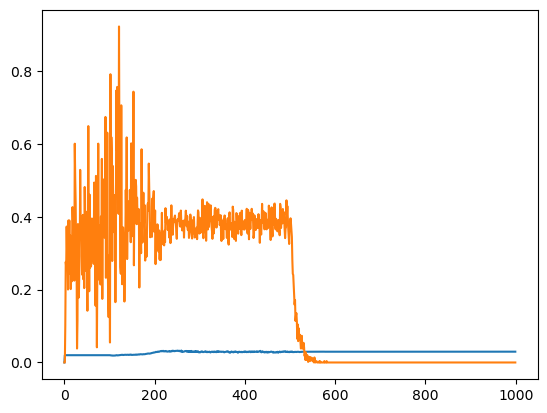

,HHI,Distance
0,0.000000,0.000000
1,0.020000,0.000000
2,0.020000,0.101200
3,0.020000,0.276300
4,0.020000,0.262933
...,...,...
995,0.029668,0.000000
996,0.029668,0.000000
997,0.029668,0.000000
998,0.029668,0.000000


In [3]:
a = model.datacollector.get_model_vars_dataframe()
a['HHI'].plot()
a['Distance'].plot()
plt.show()
a

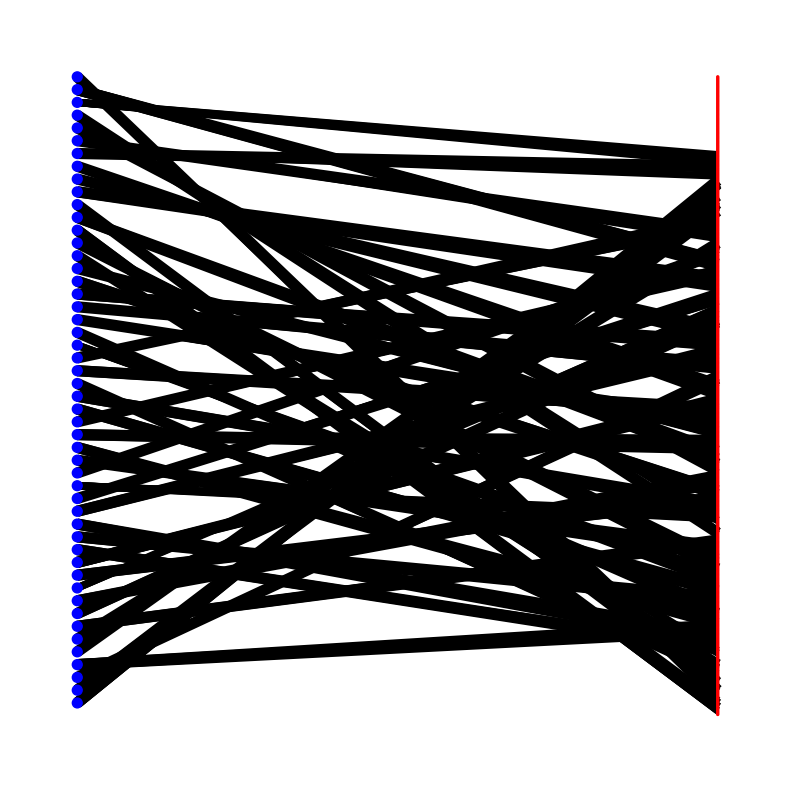

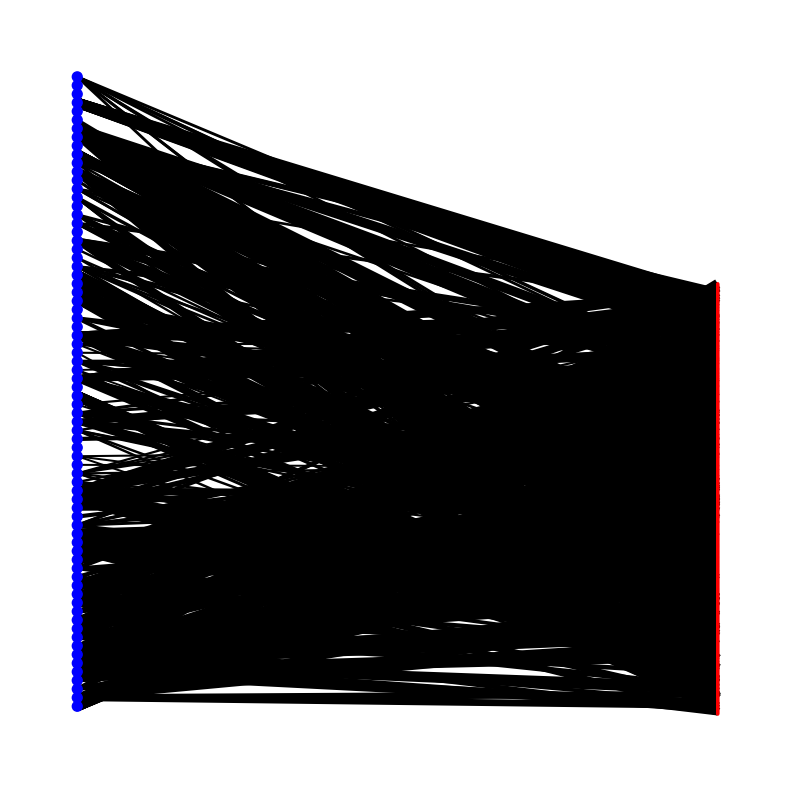

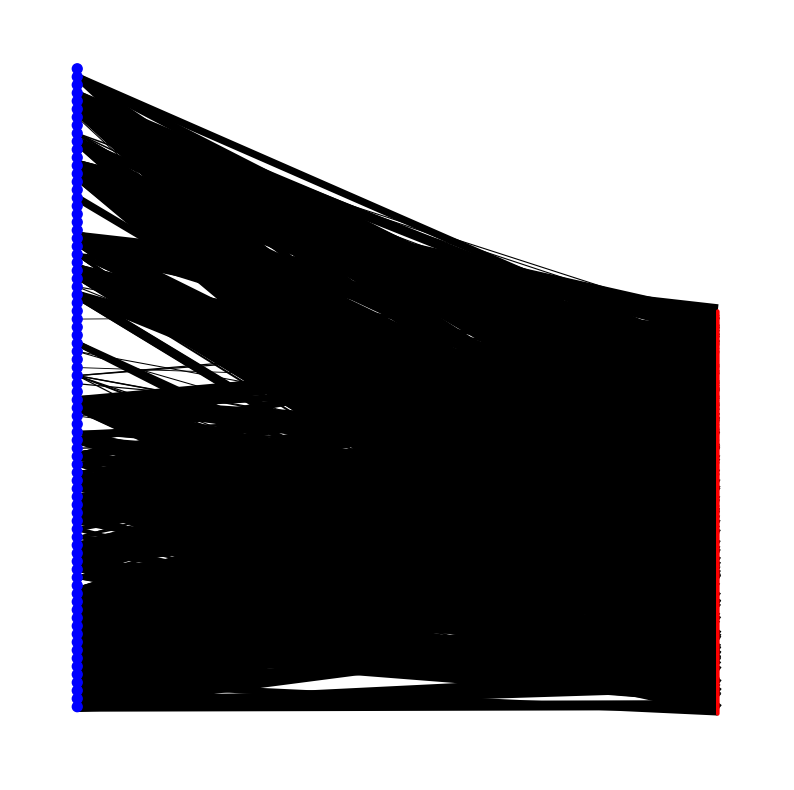

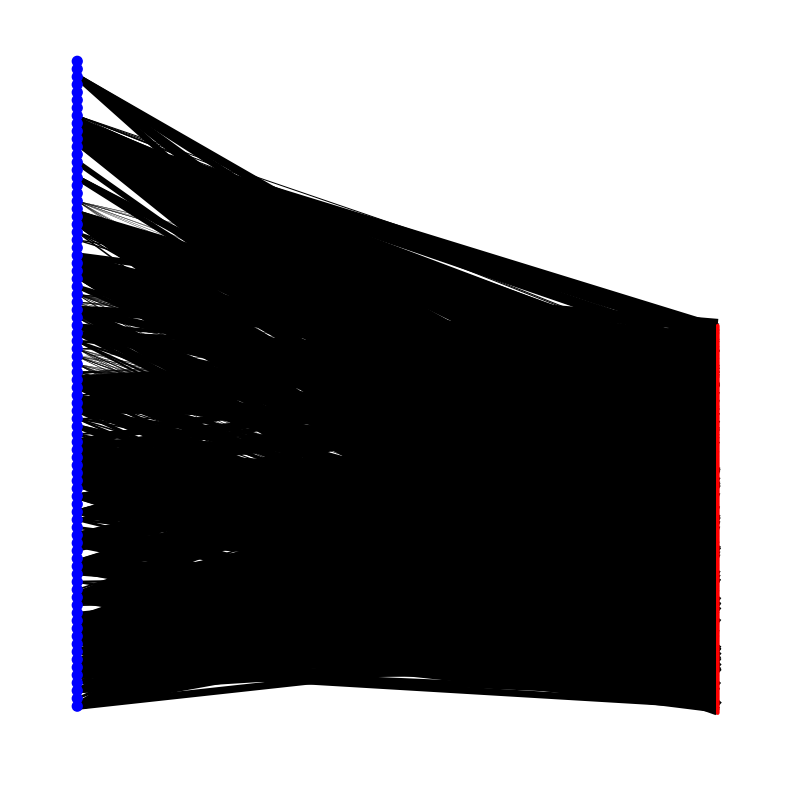

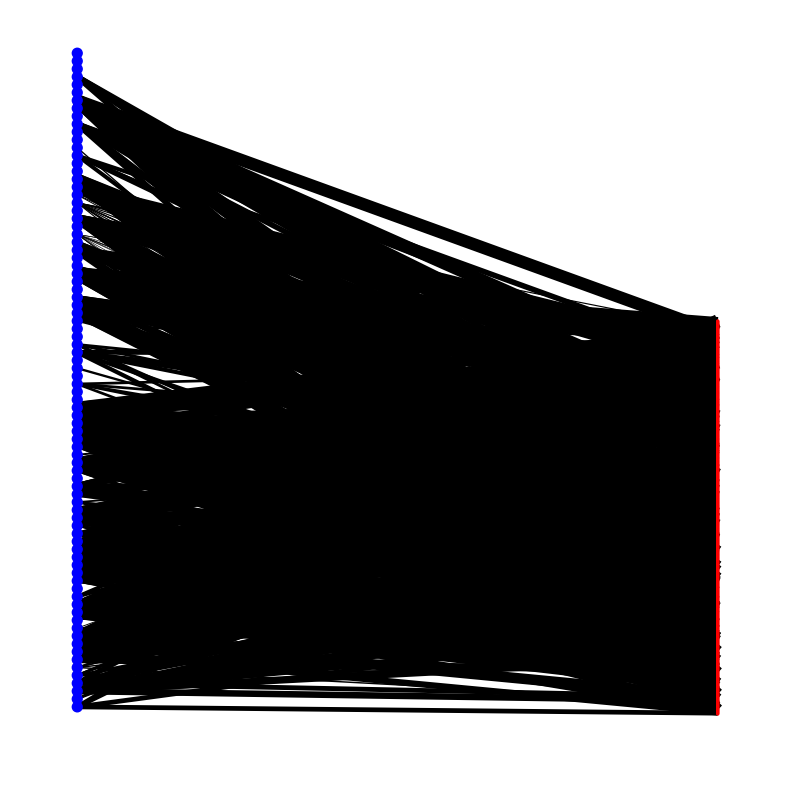

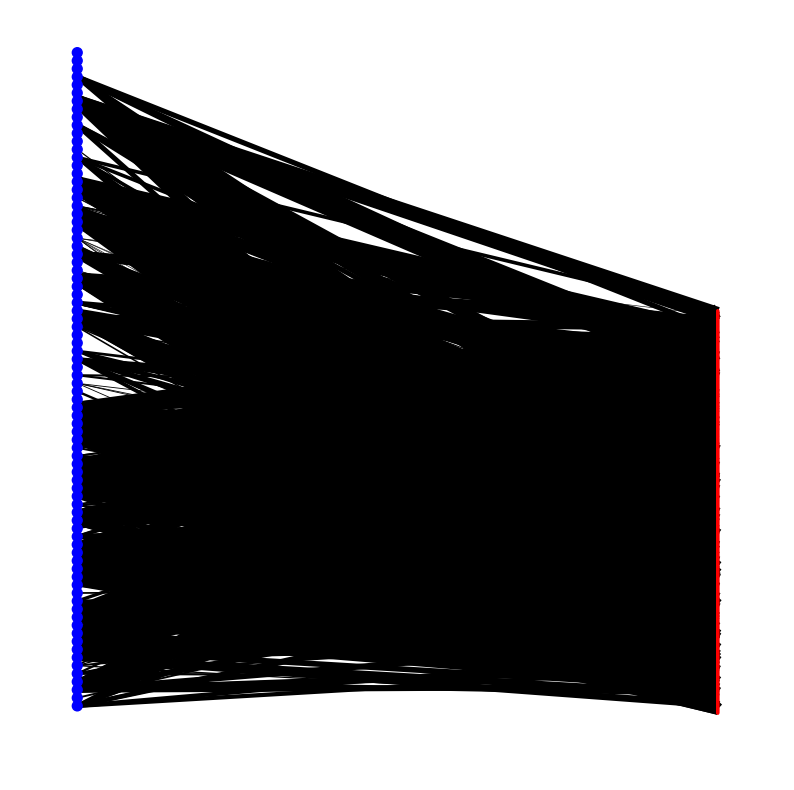

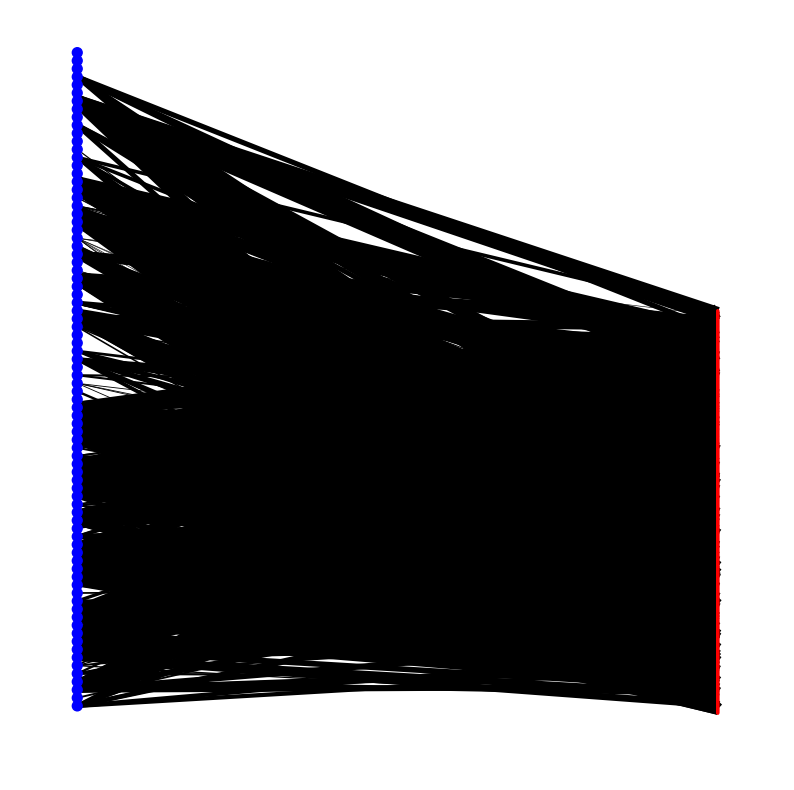

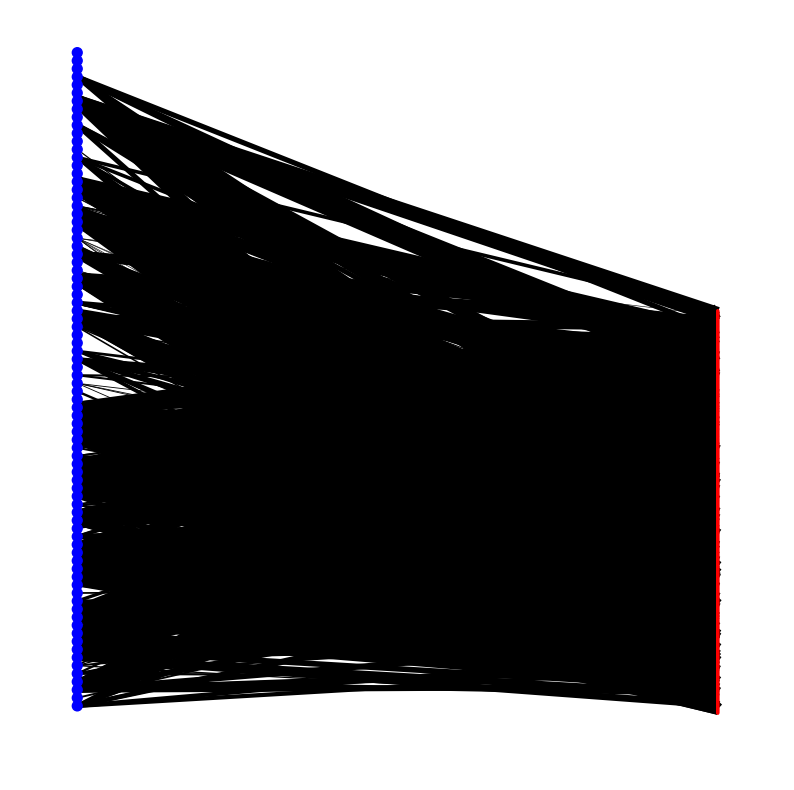

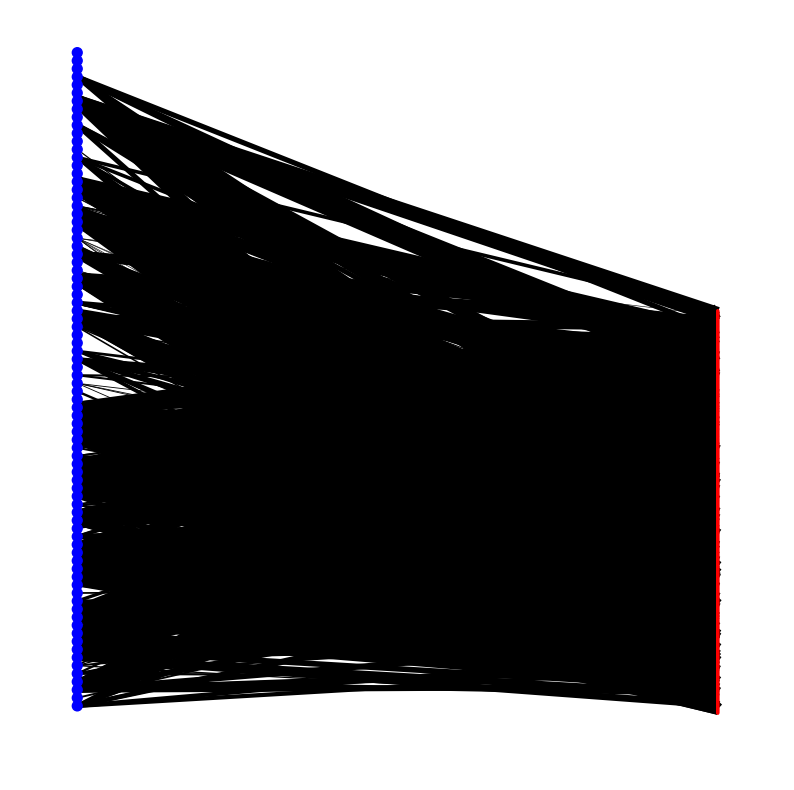

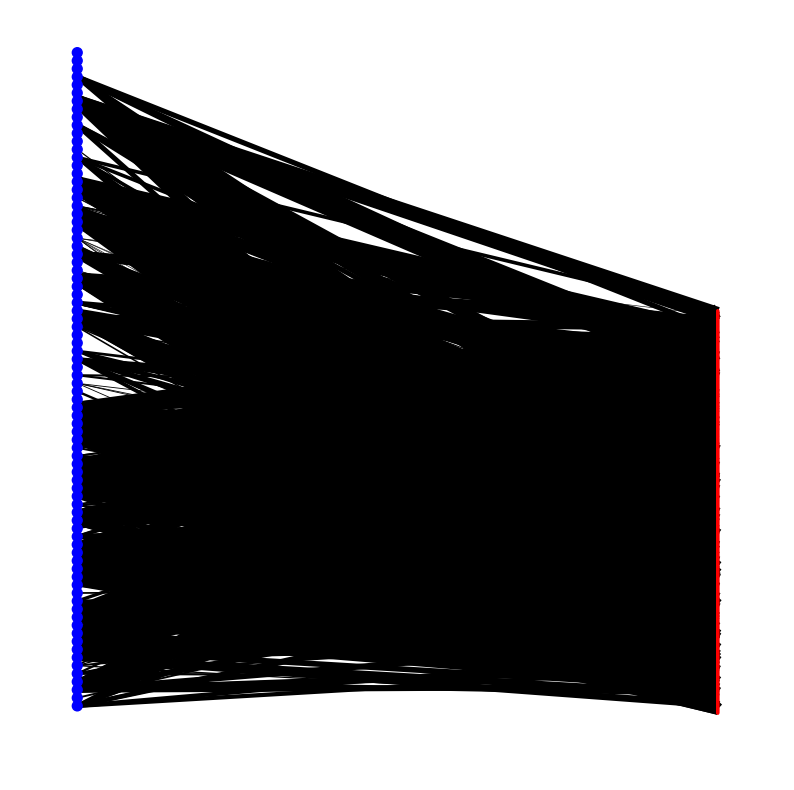

In [4]:
# draw the graph of the last step with  Weight
# remove the nodes with no edges

for i in range(1, len(model.graphs)):
    if i % 100 == 0:
        # model.graphs[i].remove_nodes_from(list(nx.isolates(model.graphs[i])))
        # color the nodes by type
        color_map = []
        node_map = []
        pos = {}
        f = 1
        h = 1
        for node in model.graphs[i]:
            if type(node) is Firm:
                color_map.append('blue')
                node_map.append(50)
                pos[node] = (1, f * 10)
                f += 1
            else:
                color_map.append('red')
                node_map.append(2)
                pos[node] = (2, h)
                h += 1
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        # draw the bipartite graph using the node color map

        nx.draw(model.graphs[i], with_labels=False, width=[model.graphs[i][u][v]['weight'] for u,v in model.graphs[i].edges()], node_color = color_map, node_size = node_map, pos=pos)
        #plt.show()



In [5]:
df = model.datacollector.get_agent_vars_dataframe().reset_index()

In [6]:
# for each Step, computes the HHI for each Firm
df_firm = df.loc[df['Type'] == 'Firm']
# normalize df_firm['Revenue'] in each Step
df_firm['Market_share'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x/x.sum())
# square the Market_share
df_firm['R'] = df_firm['Market_share']**2
# compute the HHI
HHI = df_firm.groupby(['Step'])['R'].sum()

#df_firm['HHI'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x**2).groupby(['Step', 'Type']).transform('sum')



/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_5548/3487603048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firm['Market_share'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x/x.sum())
/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_5548/3487603048.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firm['R'] = df_firm['Market_share']**2


/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_5548/1323036616.py:18: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  prev = nx.adjacency_matrix(graph_a).A
/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_5548/1323036616.py:19: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  curr = nx.adjacency_matrix(graph_b).A


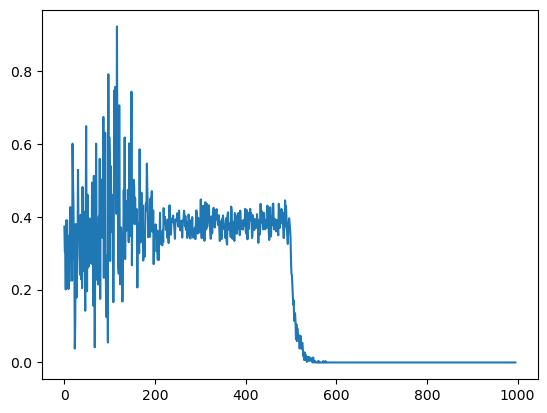

In [7]:
def compute_change(graph_a, graph_b):
    additions = graph_b.nodes() - graph_a.nodes() 
    deletions = graph_a.nodes() - graph_b.nodes() 
    graph_a = graph_a.copy()
    graph_b = graph_b.copy()
    change = 0
    changes = set()
    # Compute the change for the deletions (n.b. additions are handled automatically)
    for n in deletions:
        for e in graph_a[n]:
            if (n,e) not in changes and (e,n) not in changes:
                change += graph_a[n][e]['weight']
                changes.add((n,e))
    # Add the missing nodes and remove the extra ones from graph a, so it has the same shape as graph b.
    graph_a.remove_nodes_from(deletions)
    graph_a.add_nodes_from(additions)
    
    prev = nx.adjacency_matrix(graph_a).A
    curr = nx.adjacency_matrix(graph_b).A
    # Divide by two because the matrix has two entries per pair of nodes (it is undirected)
    change += sum(sum(abs(curr - prev))) / 2
    maximum = sum(sum(prev))
    return change / maximum

def change_metric(graphs):
    """
    Takes in a list of transaction graphs and returns a list of the change between each
    """
    output = [0]
    for i in range(0, len(graphs)):
        output.append(compute_change(graphs[i-1], graphs[i]))
    return output

our_metric = change_metric(model.graphs[1:])
our_metric = our_metric[5:]
plt.plot(our_metric)

<AxesSubplot:xlabel='Step'>

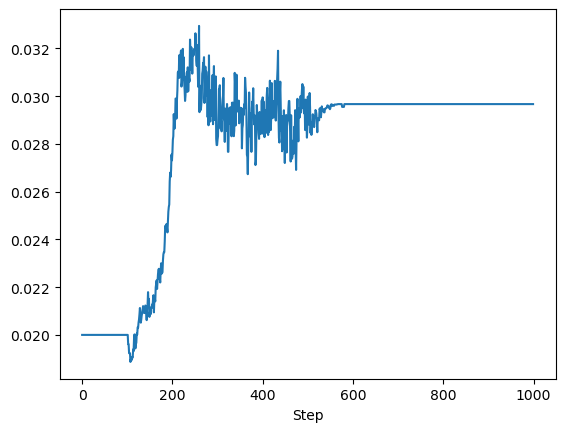

In [8]:
HHI.plot()

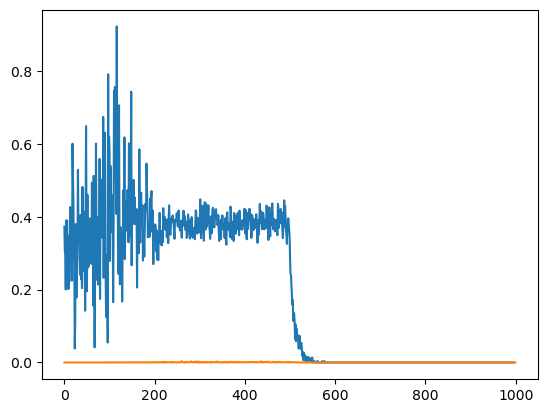

In [9]:
def compute_hhi_diff(hhi):
    hhi_diff = [0]

    for i in range(1, len(hhi)):
        change = abs(hhi[i] - hhi[i-1])
        hhi_diff.append(change)

    return hhi_diff

plt.plot(our_metric)
plt.plot(compute_hhi_diff(HHI))

<AxesSubplot:xlabel='Step', ylabel='budget'>

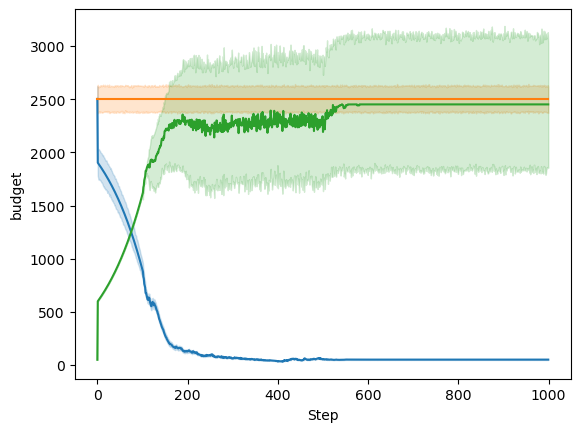

In [10]:
#sns.lineplot(data=df, y='Revenue', x='Step', estimator='sum')
sns.lineplot(data=df, y='budget', x='Step', estimator='sum')
sns.lineplot(data=df, y='Initial_budget', x='Step', estimator='sum')
sns.lineplot(data=df, y='Revenue', x='Step', estimator='sum')


/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_5548/469125640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firm['number'] = 1


<AxesSubplot:xlabel='Step', ylabel='number'>

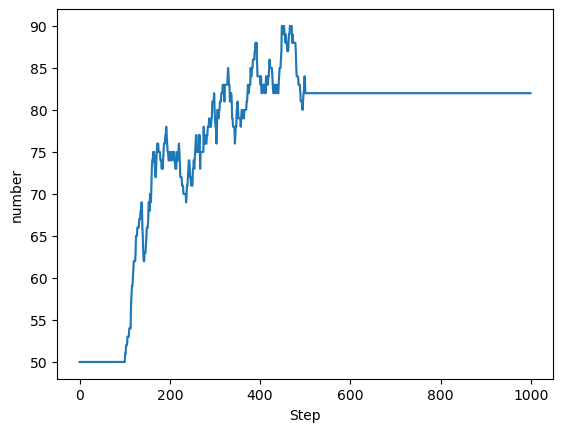

In [11]:
# draw the graph with the number of firms
# count the number of AgentID in each step
df_firm['number'] = 1

sns.lineplot(data=df_firm, x='Step', y='number', estimator='sum')


<AxesSubplot:xlabel='Step', ylabel='Net_worth'>

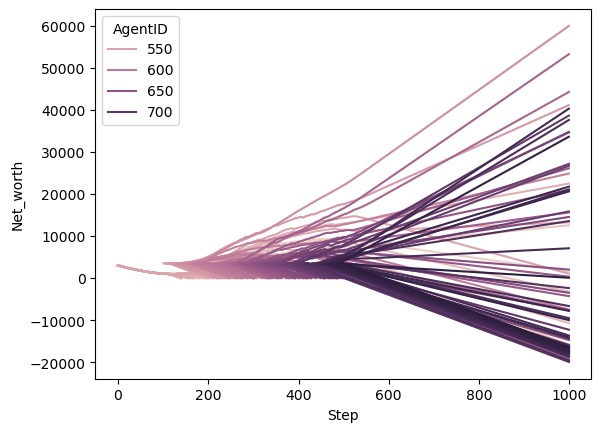

In [12]:
sns.lineplot(data=df_firm, y='Net_worth', x='Step', hue='AgentID')

In [13]:
sns.lineplot(data=df_firm, y='Quality', x='Step', hue = 'AgentID')

<AxesSubplot:xlabel='Step', ylabel='Price'>

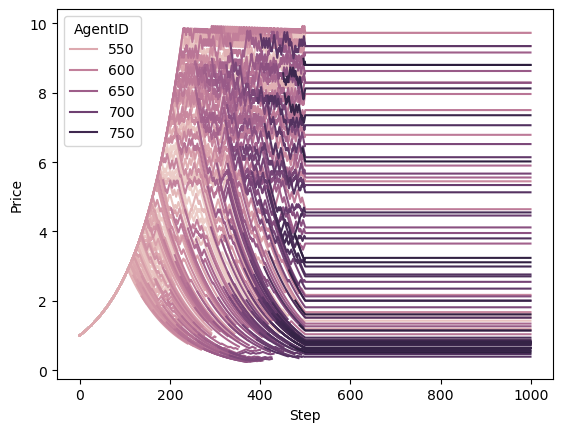

In [ ]:
sns.lineplot(data=df_firm, y='Price', x='Step', hue = 'AgentID')

<AxesSubplot:xlabel='Step', ylabel='Quantity_sold'>

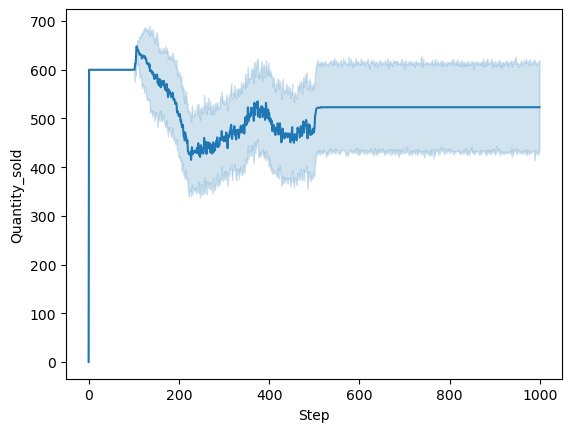

In [ ]:
sns.lineplot(data=df, y='Quantity_sold', x='Step', estimator='sum')


<AxesSubplot:xlabel='Step', ylabel='Revenue'>

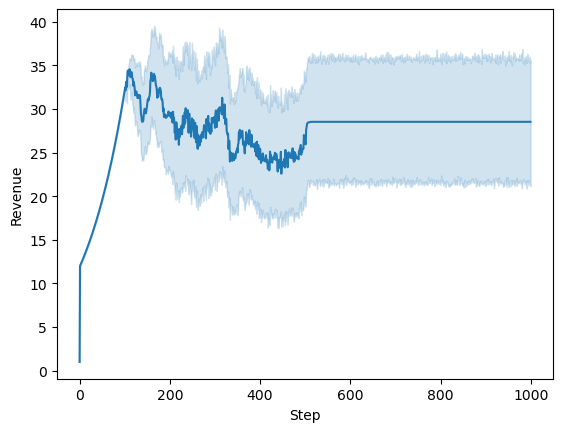

In [ ]:
sns.lineplot(data=df, y='Revenue', x='Step')


<AxesSubplot:>

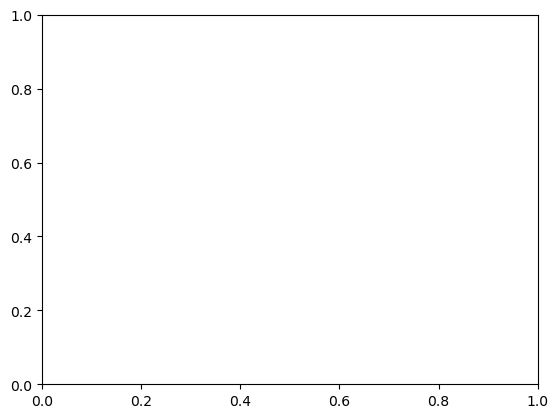

In [ ]:
sns.lineplot(data=df.loc[df['AgentID'] == 1020],
             y='Revenue', x='Step', hue='AgentID')


In [ ]:
df.loc[(df['Step'] == 0) & (df['Type'] == 'Household')].sort_values('budget')


,Step,AgentID,Type,Quality,Revenue,Quantity_sold,Price,Net_worth,Initial_budget,budget
495,0,496,Household,NaN,NaN,NaN,NaN,NaN,0.032268,0.032268
185,0,186,Household,NaN,NaN,NaN,NaN,NaN,0.034893,0.034893
398,0,399,Household,NaN,NaN,NaN,NaN,NaN,0.075479,0.075479
192,0,193,Household,NaN,NaN,NaN,NaN,NaN,0.086484,0.086484
341,0,342,Household,NaN,NaN,NaN,NaN,NaN,0.099698,0.099698
...,...,...,...,...,...,...,...,...,...,...
50,0,51,Household,NaN,NaN,NaN,NaN,NaN,9.934824,9.934824
6,0,7,Household,NaN,NaN,NaN,NaN,NaN,9.945552,9.945552
20,0,21,Household,NaN,NaN,NaN,NaN,NaN,9.948002,9.948002
473,0,474,Household,NaN,NaN,NaN,NaN,NaN,9.978414,9.978414


In [ ]:
df.loc[(df['Step'] == 0) & (df['Type'] == 'Firm')].sort_values('Quality')


,Step,AgentID,Type,Quality,Revenue,Quantity_sold,Price,Net_worth,Initial_budget,budget
539,0,540,Firm,0.010859,1.0,0.0,1.0,3000.0,NaN,NaN
511,0,512,Firm,0.036303,1.0,0.0,1.0,3000.0,NaN,NaN
527,0,528,Firm,0.060347,1.0,0.0,1.0,3000.0,NaN,NaN
520,0,521,Firm,0.074641,1.0,0.0,1.0,3000.0,NaN,NaN
528,0,529,Firm,0.097894,1.0,0.0,1.0,3000.0,NaN,NaN
537,0,538,Firm,0.105315,1.0,0.0,1.0,3000.0,NaN,NaN
530,0,531,Firm,0.120283,1.0,0.0,1.0,3000.0,NaN,NaN
542,0,543,Firm,0.130422,1.0,0.0,1.0,3000.0,NaN,NaN
543,0,544,Firm,0.132560,1.0,0.0,1.0,3000.0,NaN,NaN
519,0,520,Firm,0.142805,1.0,0.0,1.0,3000.0,NaN,NaN


<AxesSubplot:xlabel='AgentID', ylabel='Quality'>

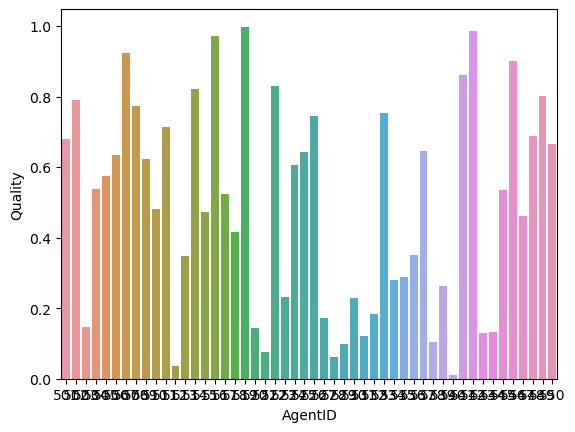

In [ ]:
sns.barplot(data=df.loc[(df['Step'] == 0) & (
    df['Type'] == 'Firm')], y='Quality', x='AgentID')


In [ ]:
df.loc[df['AgentID'] == 1009]


,Step,AgentID,Type,Quality,Revenue,Quantity_sold,Price,Net_worth,Initial_budget,budget


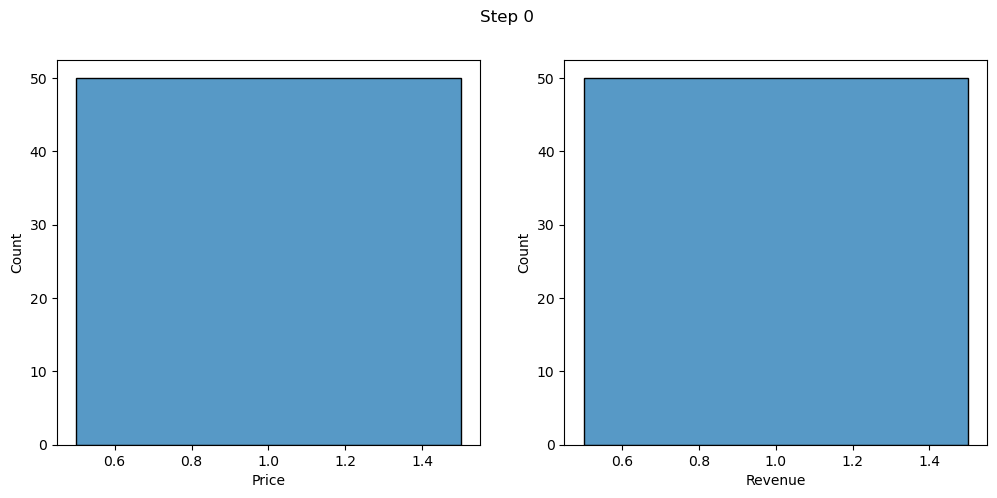

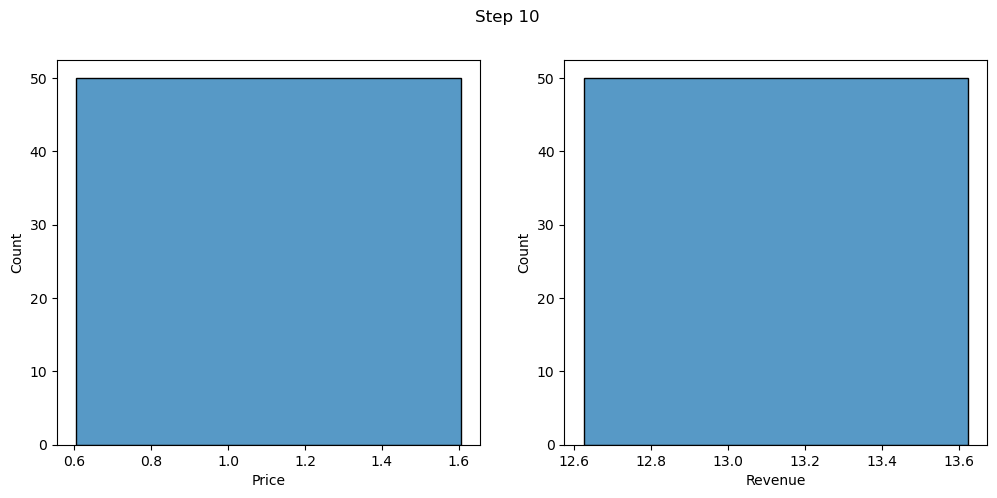

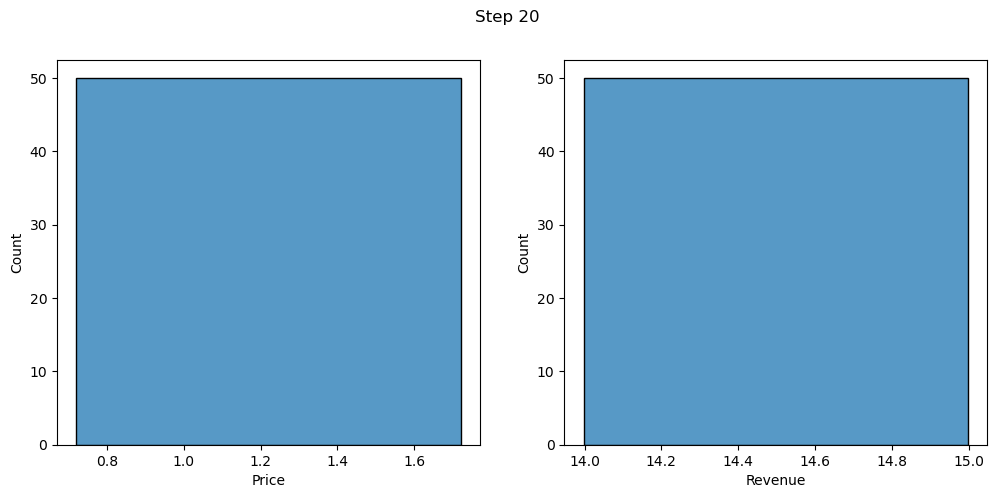

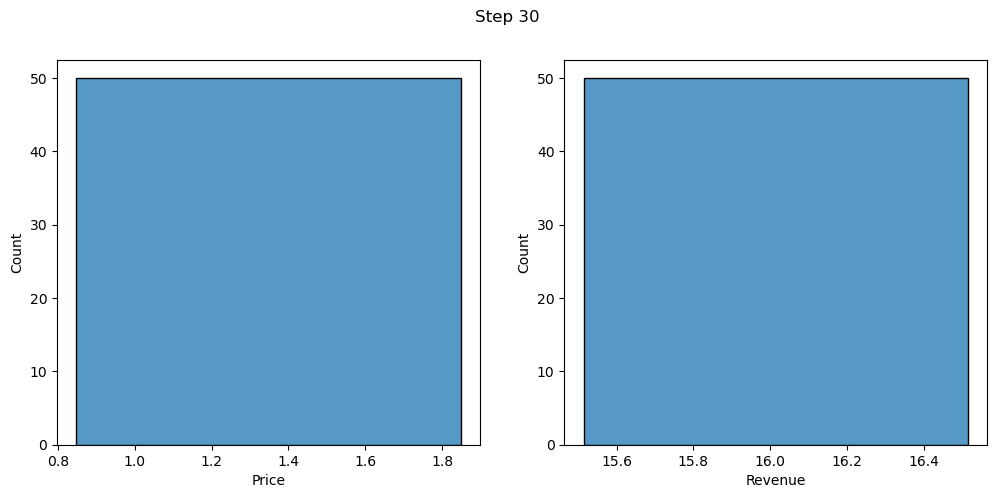

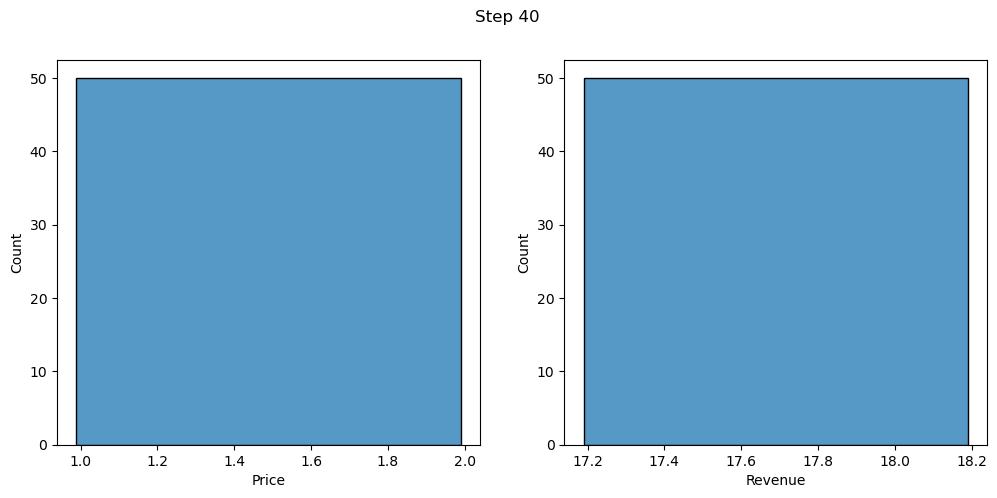

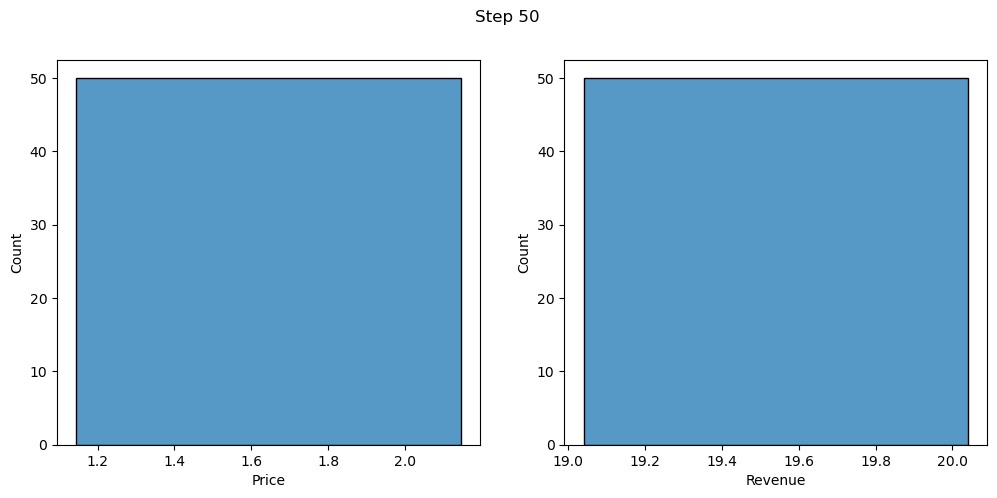

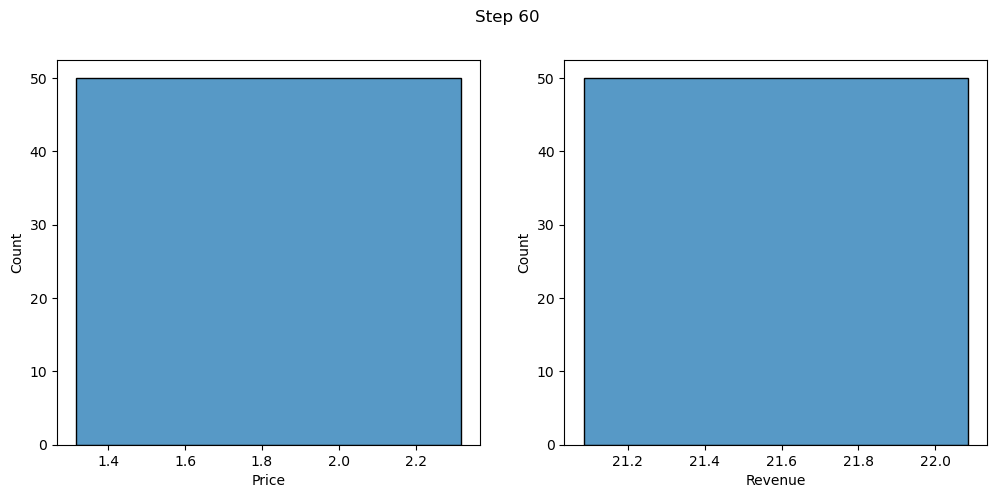

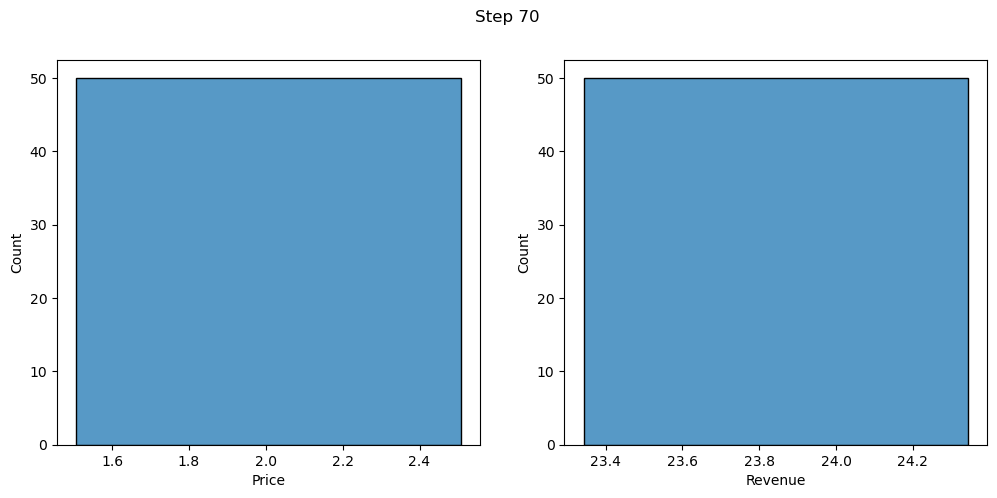

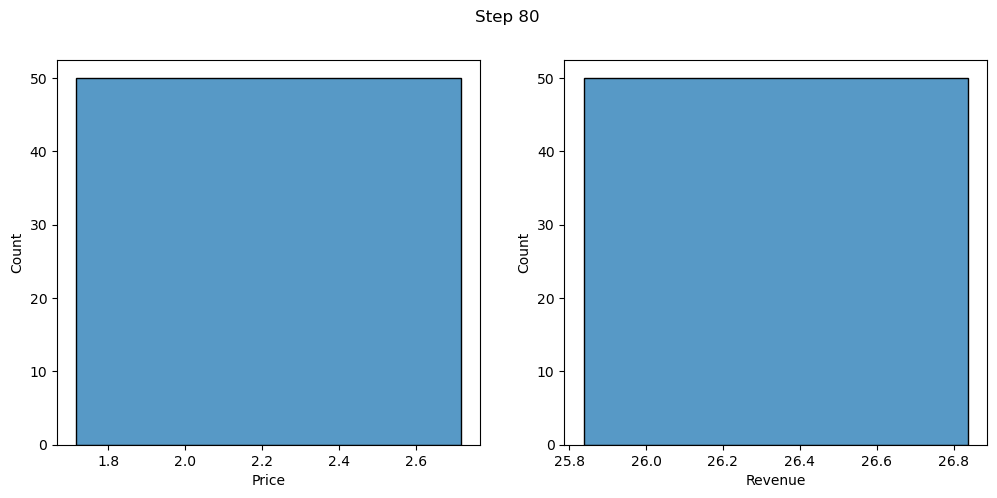

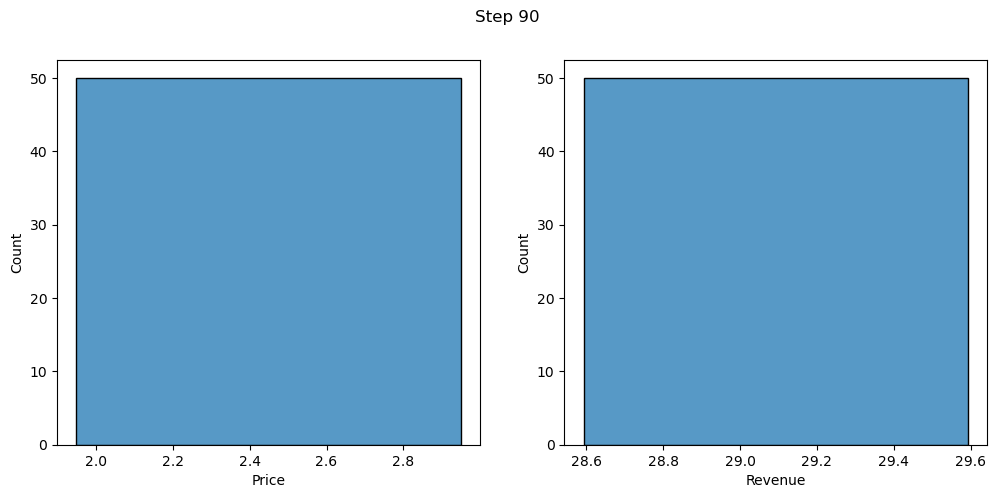

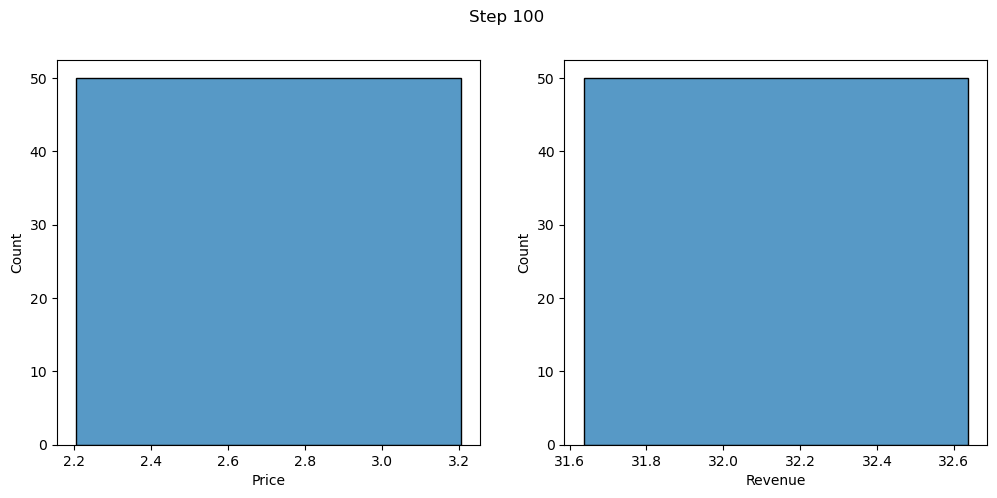

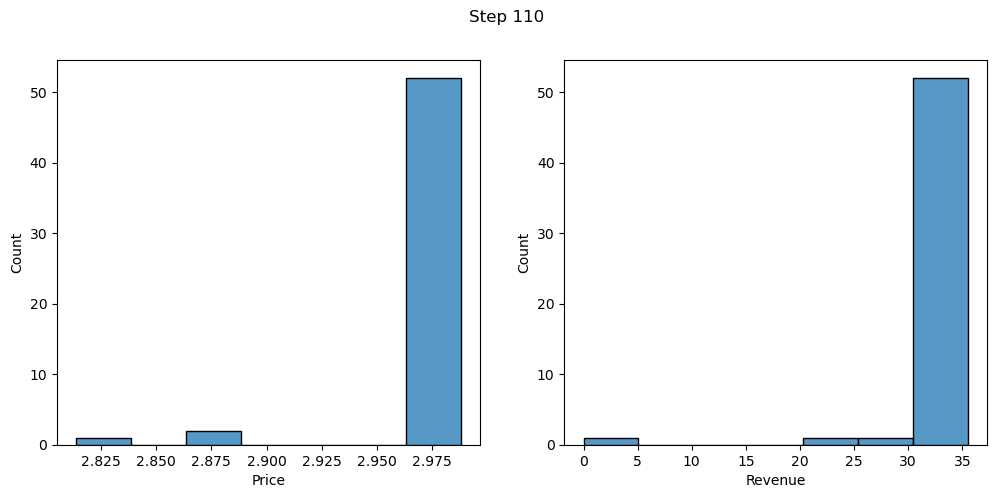

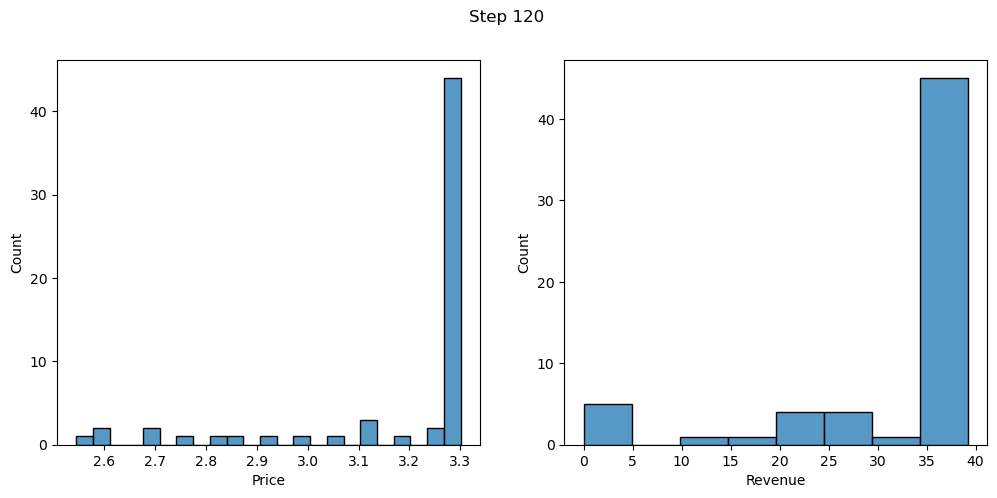

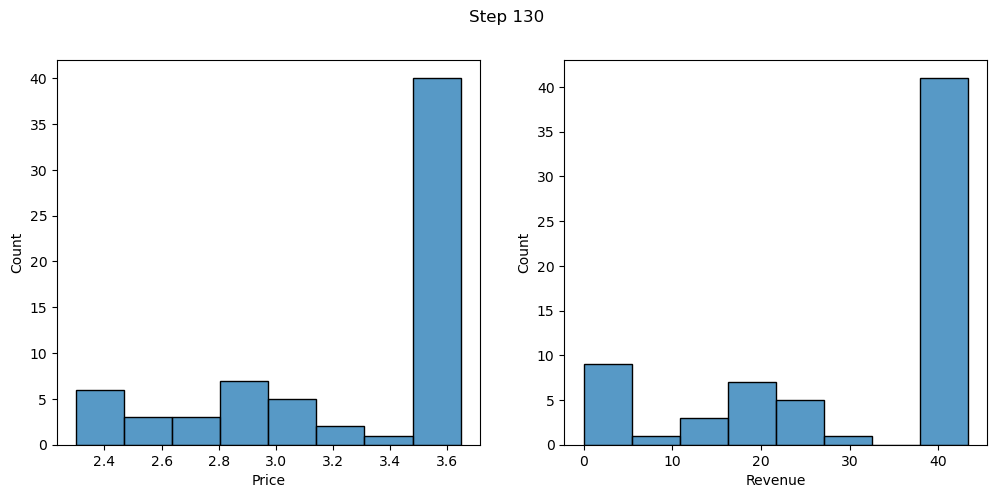

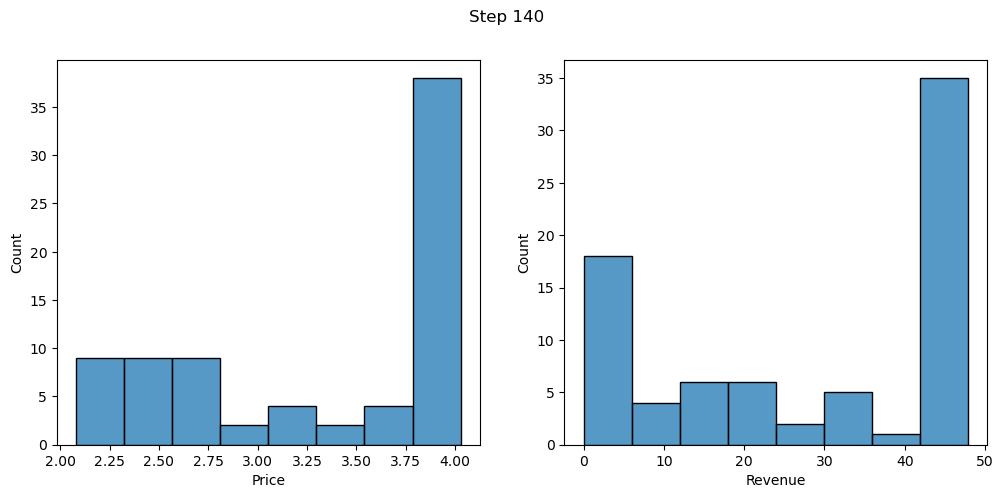

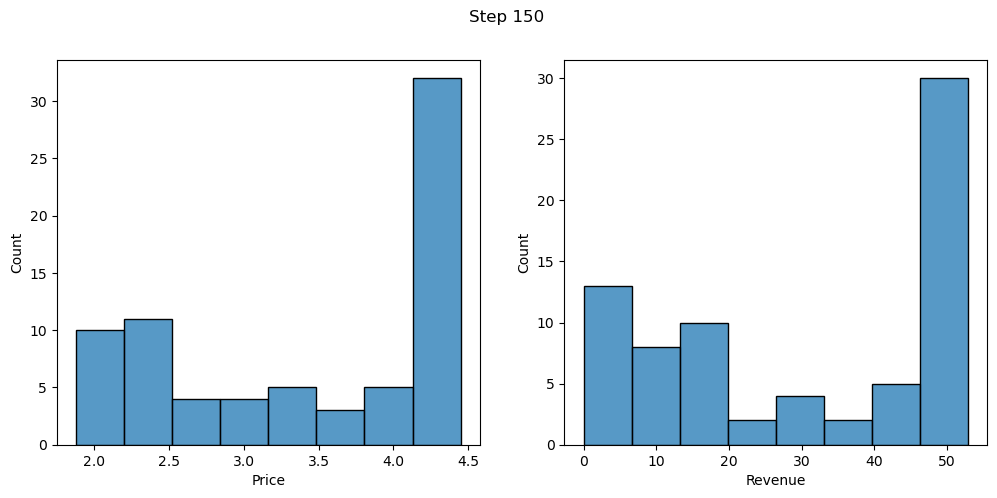

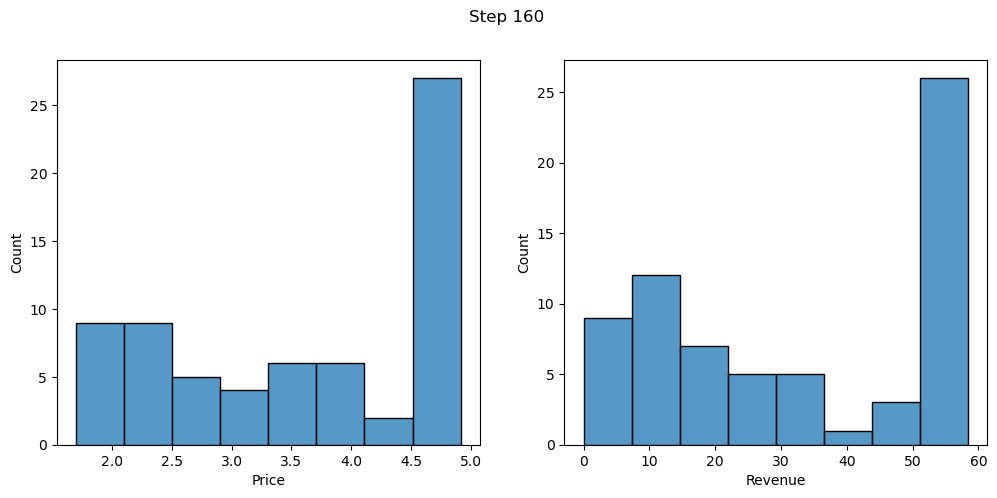

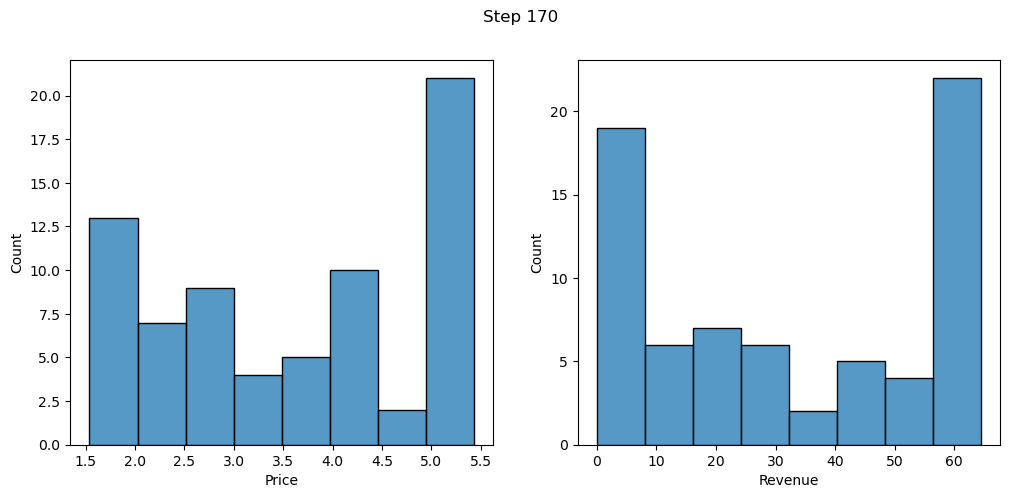

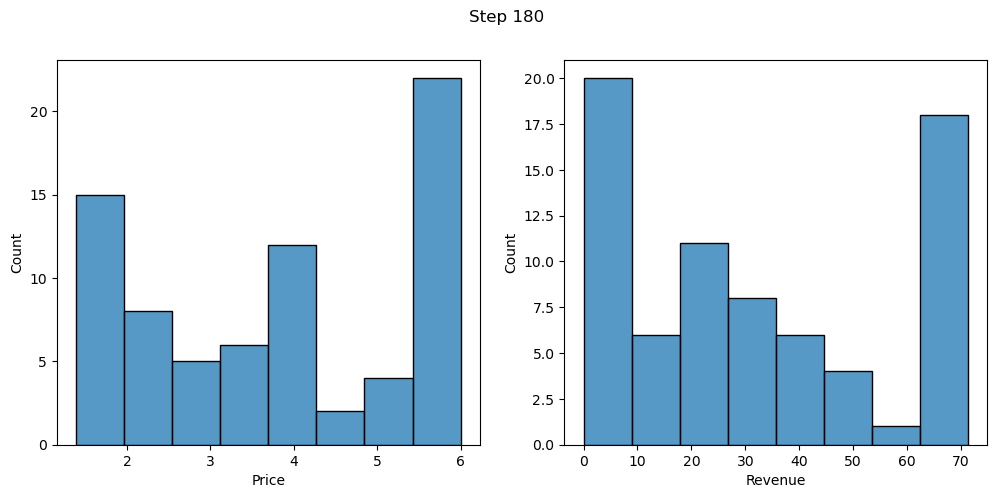

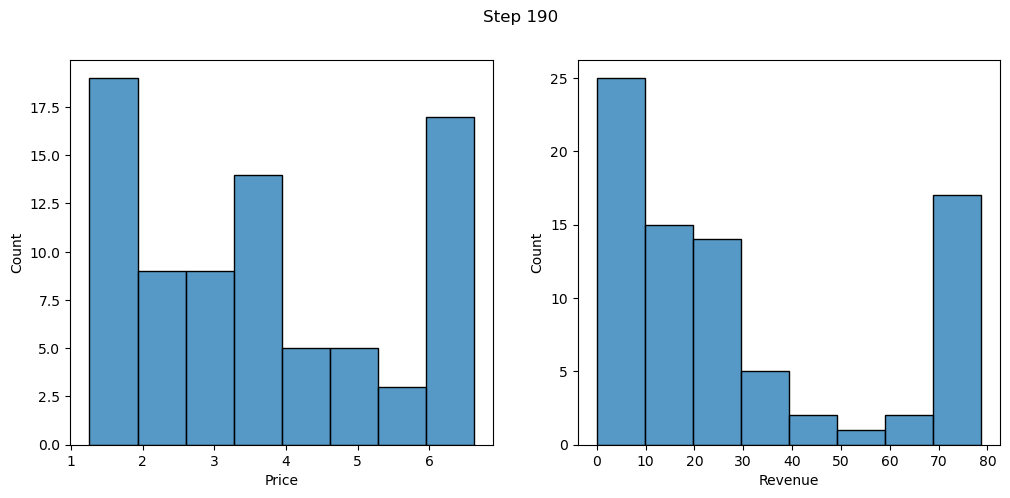

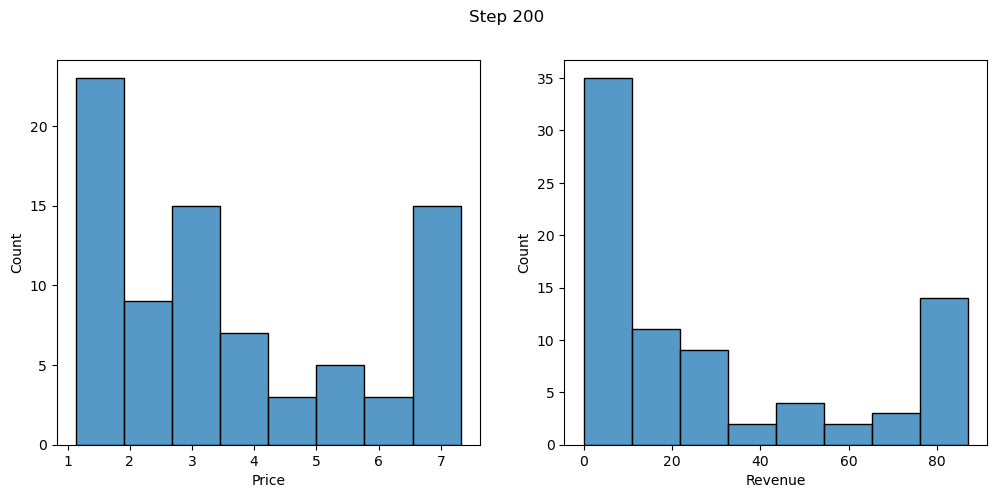

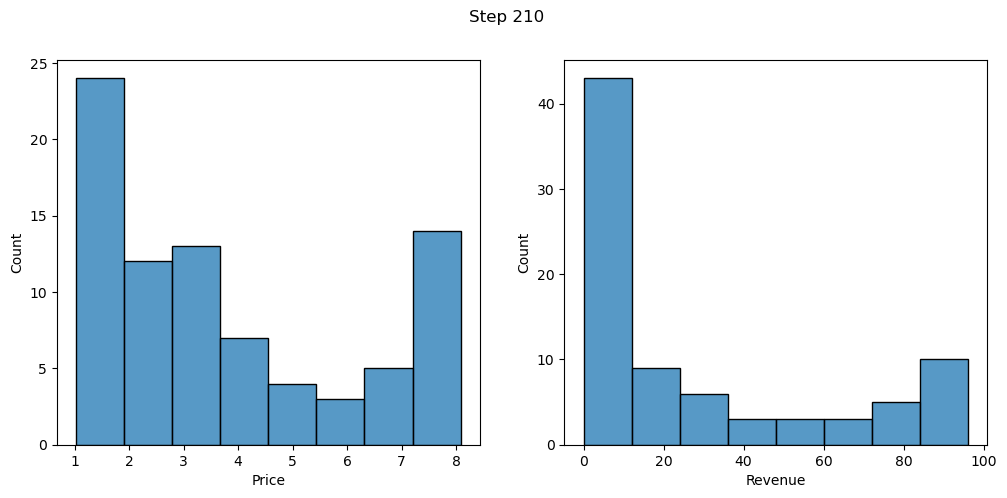

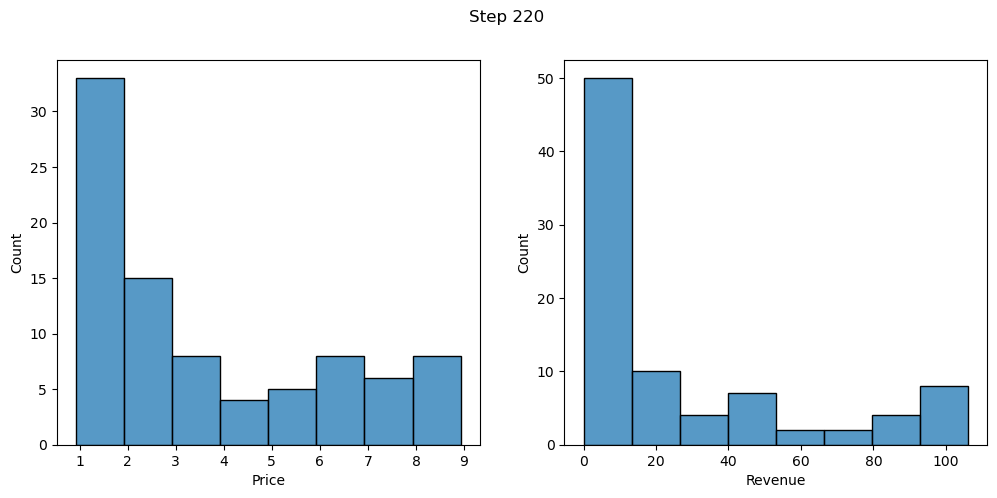

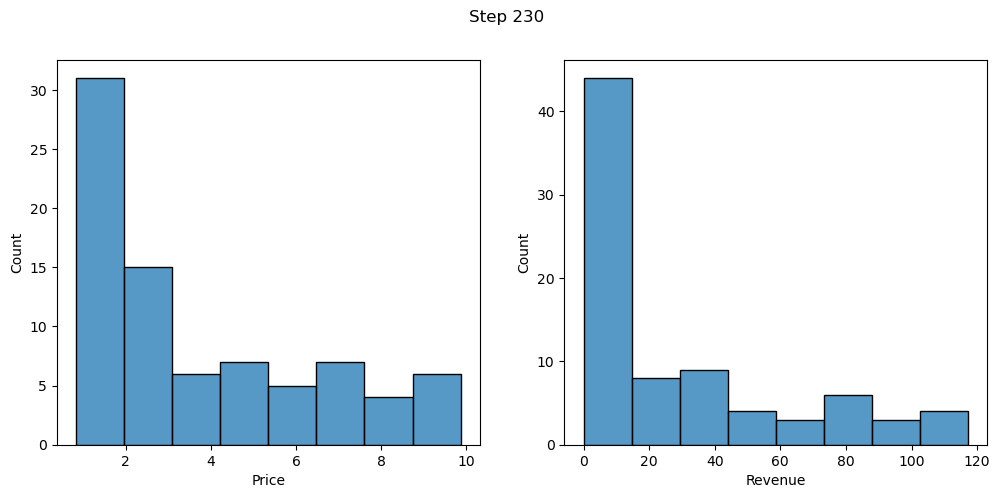

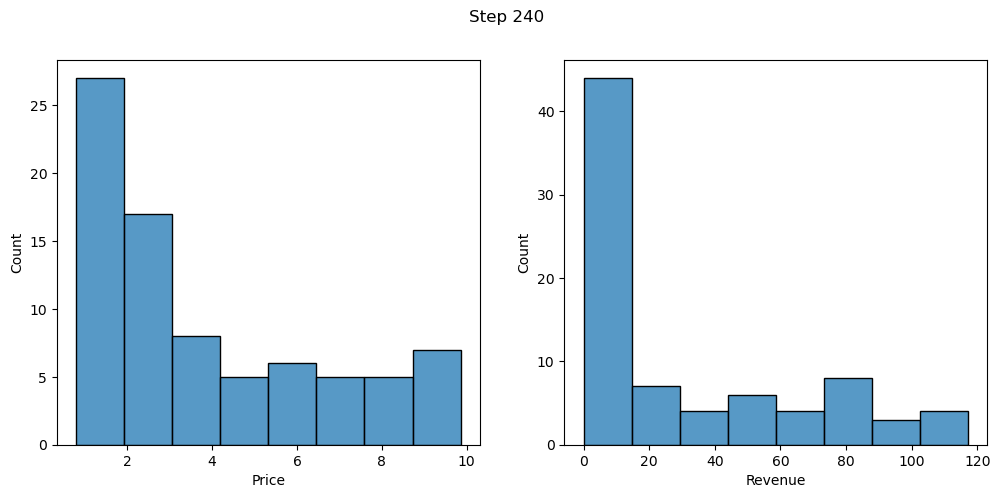

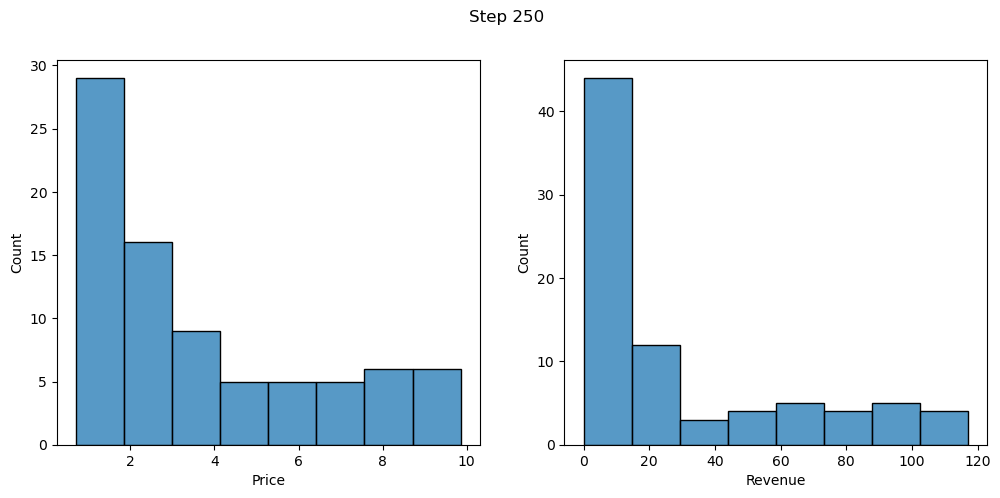

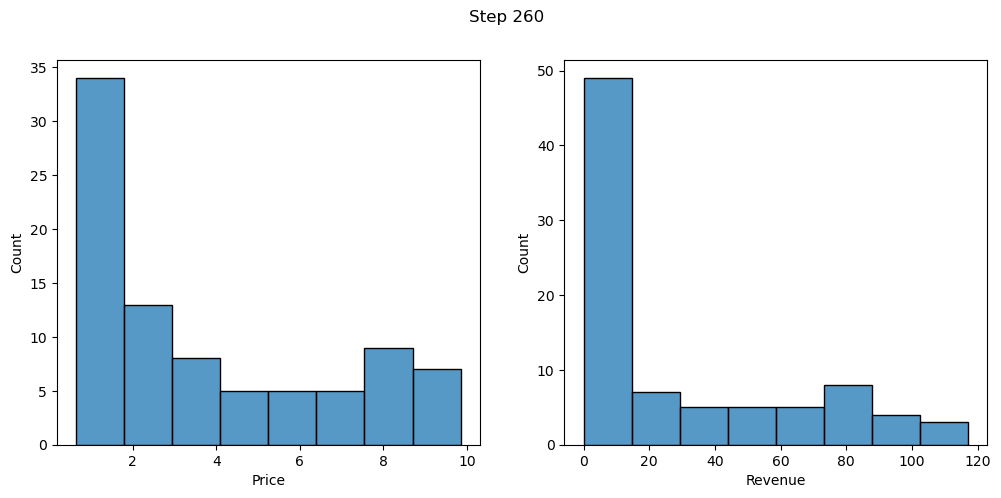

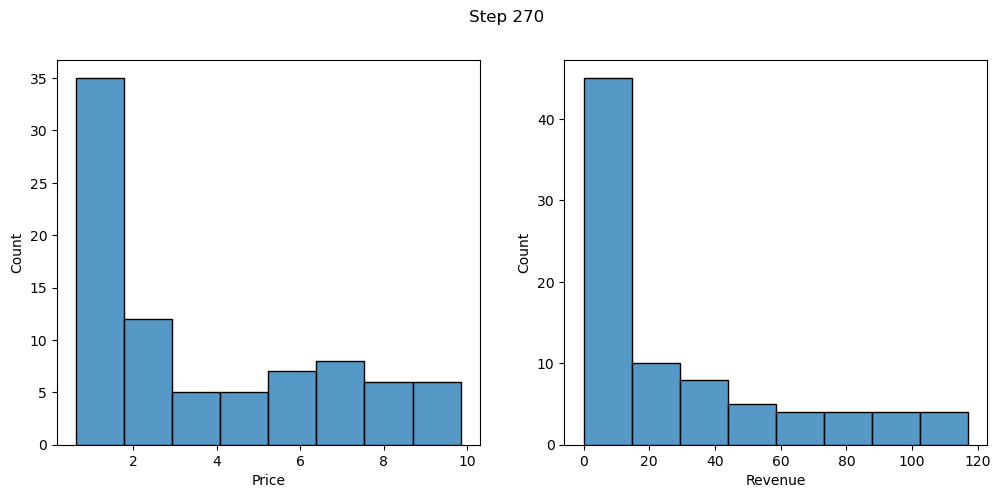

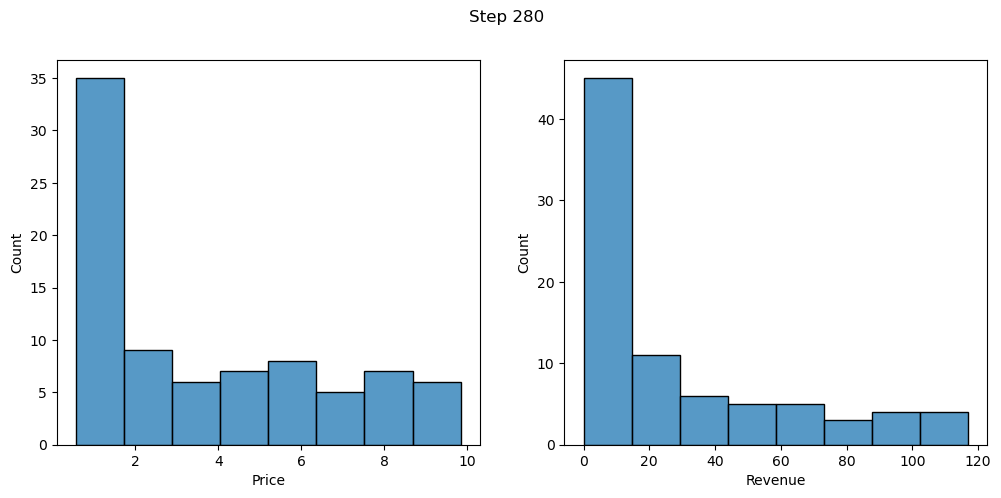

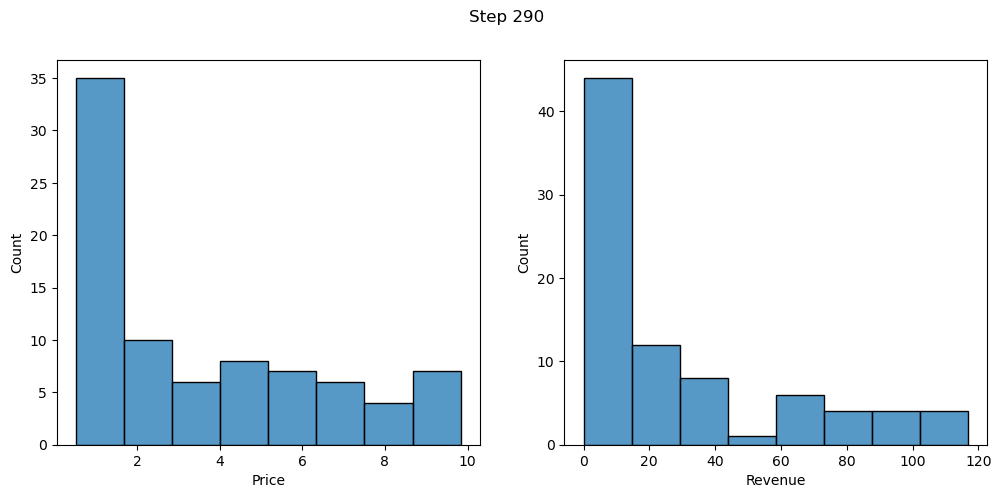

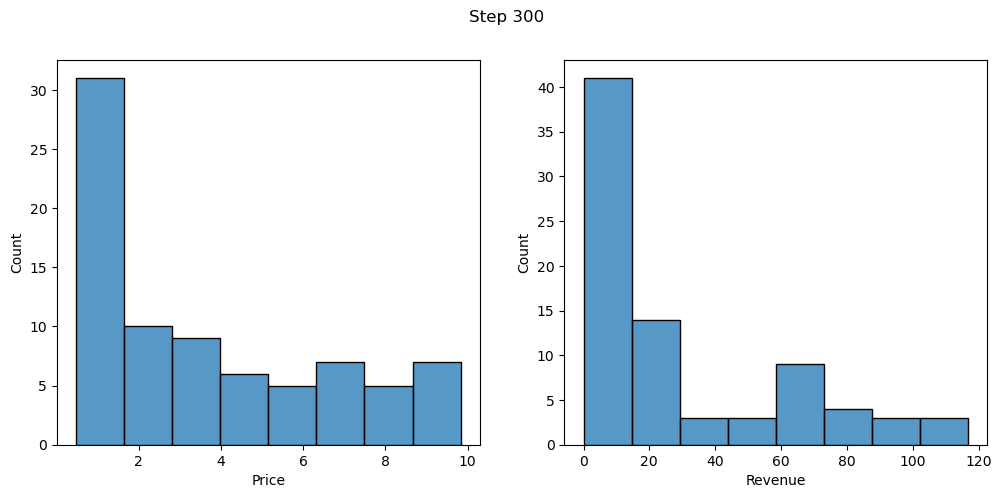

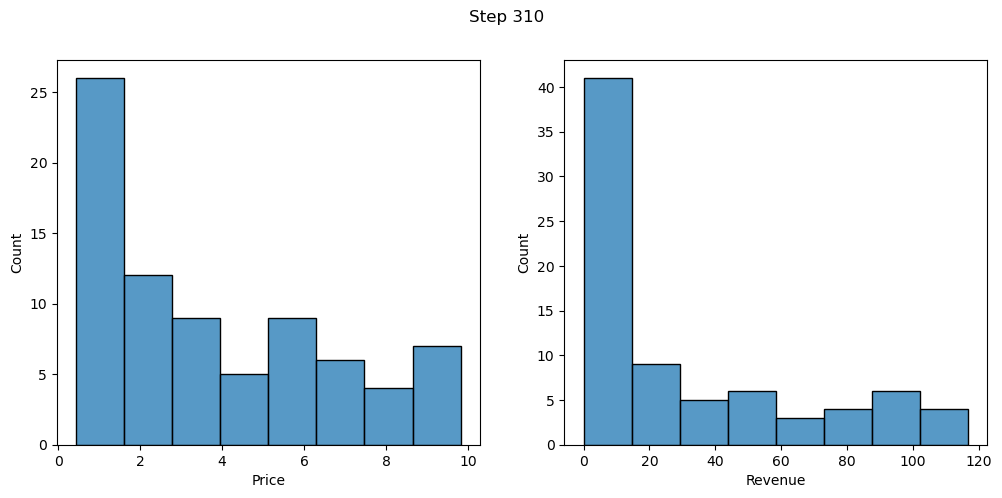

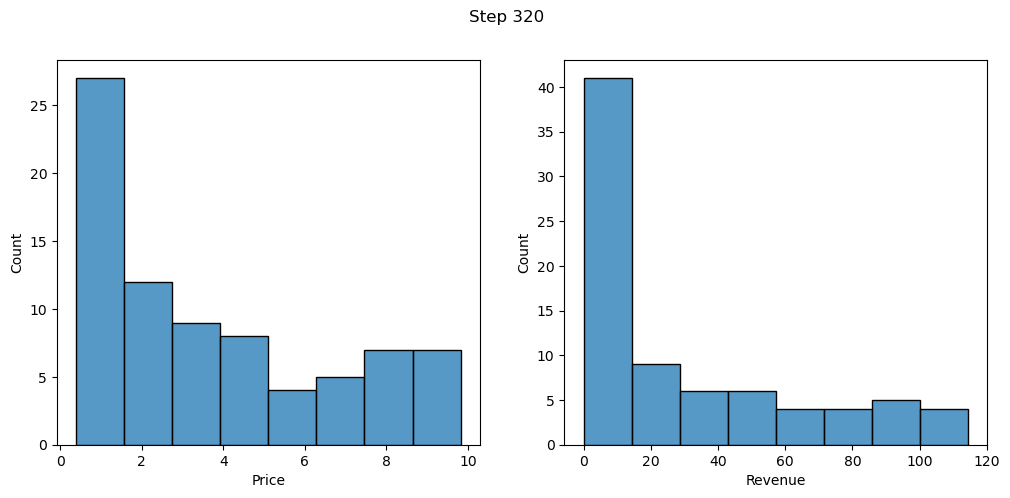

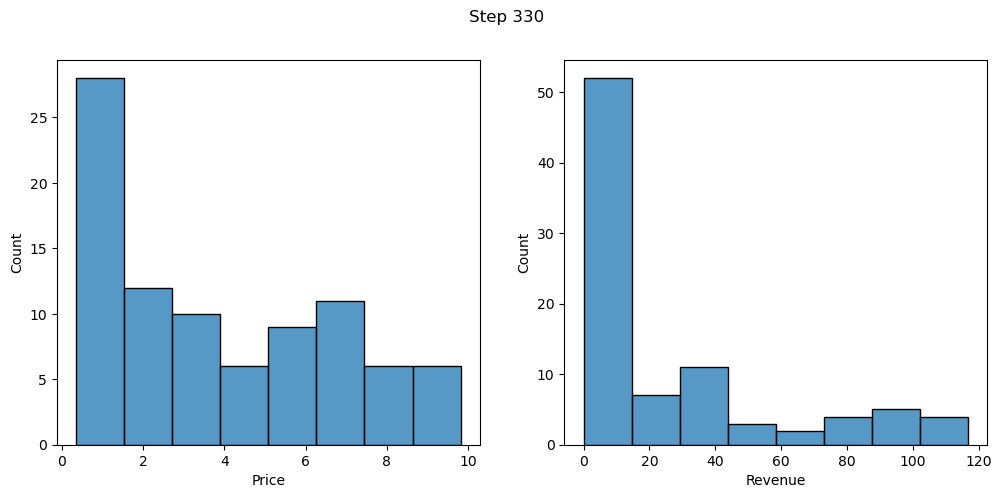

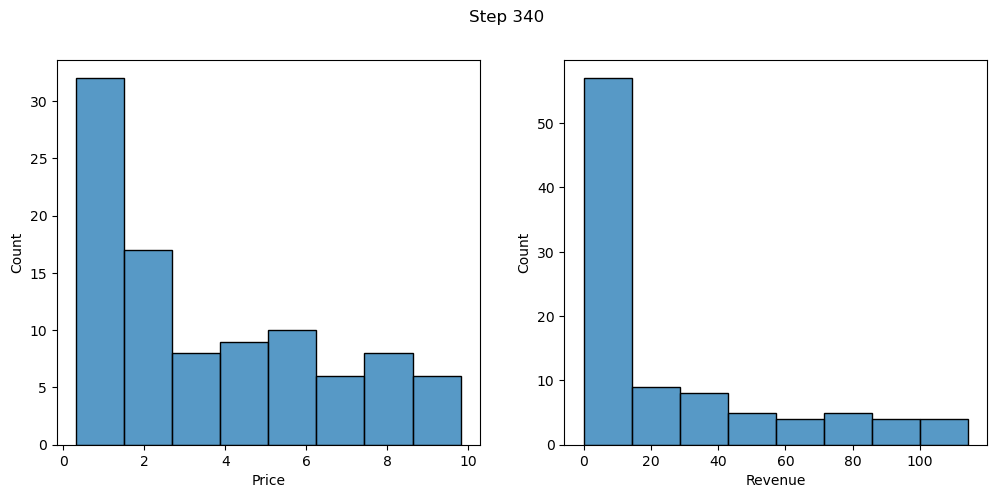

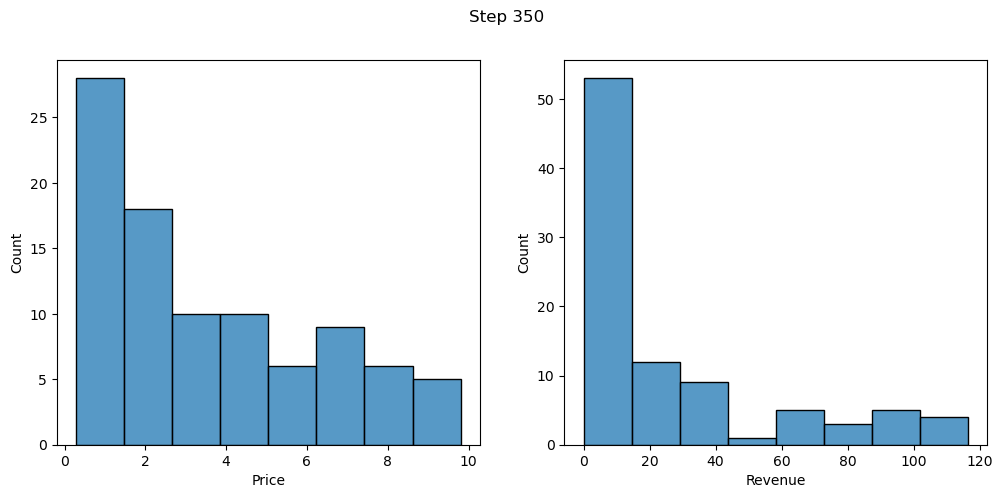

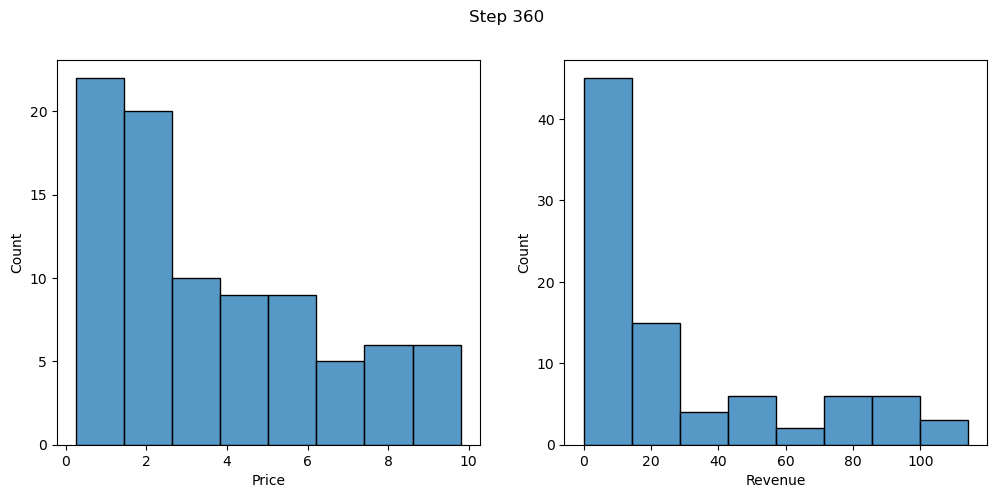

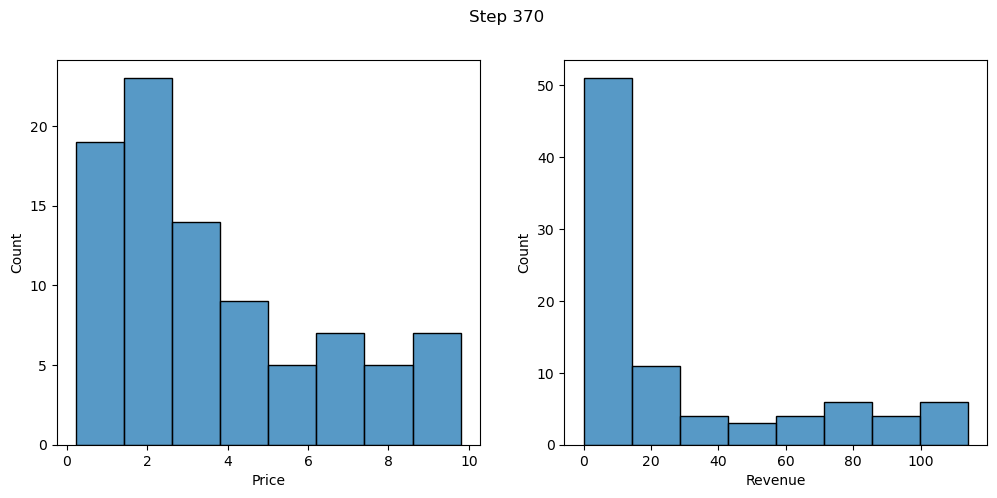

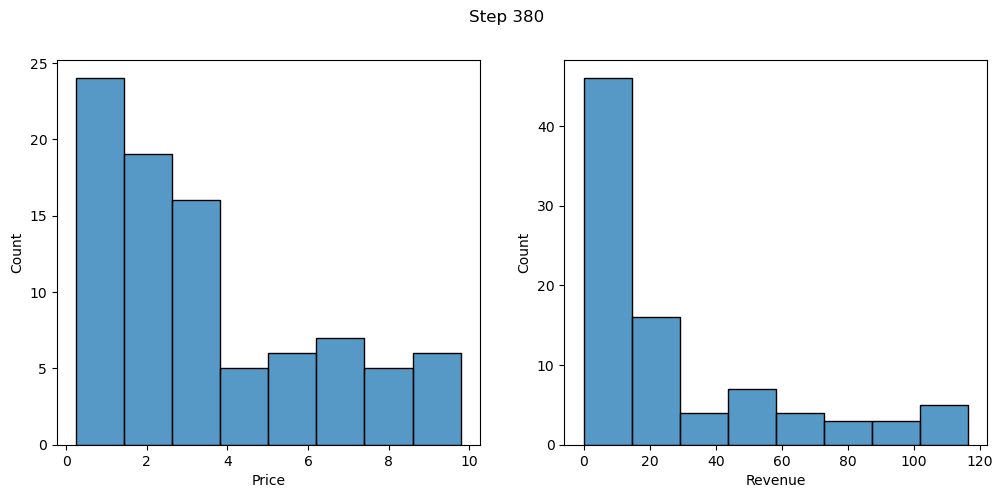

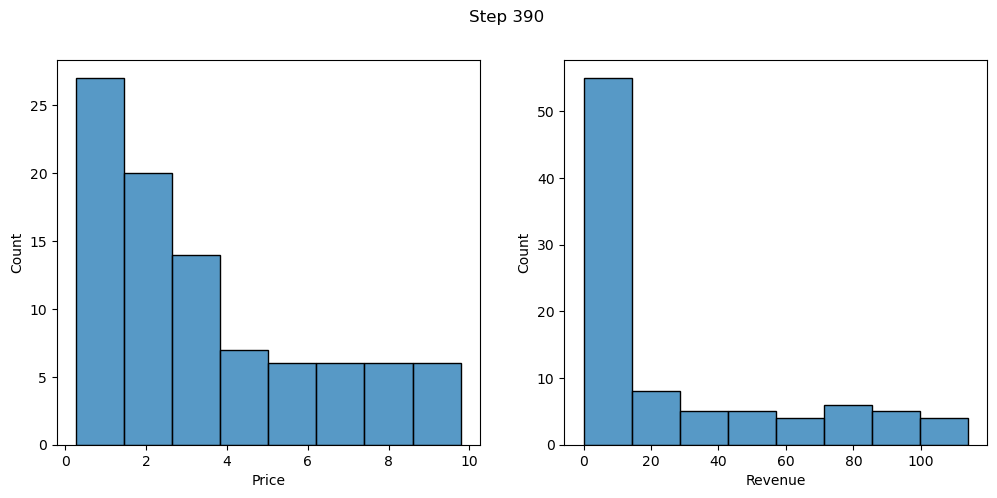

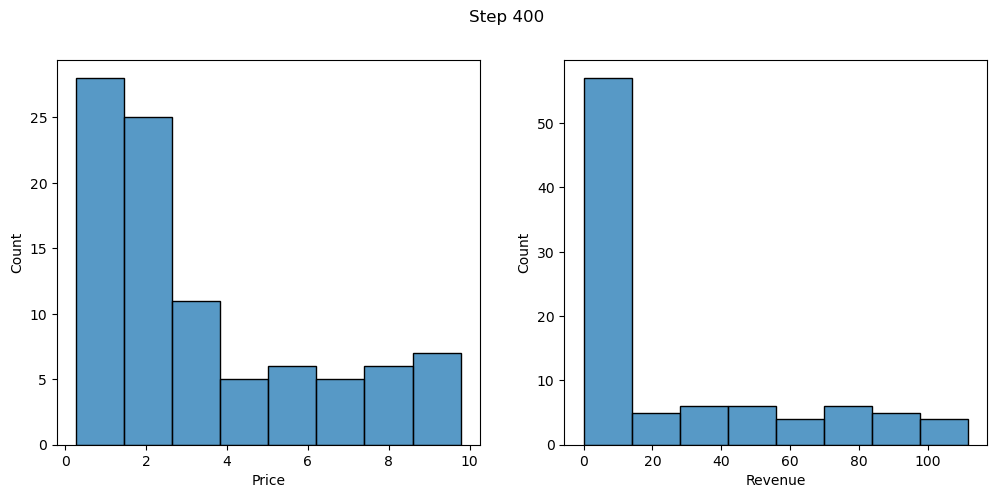

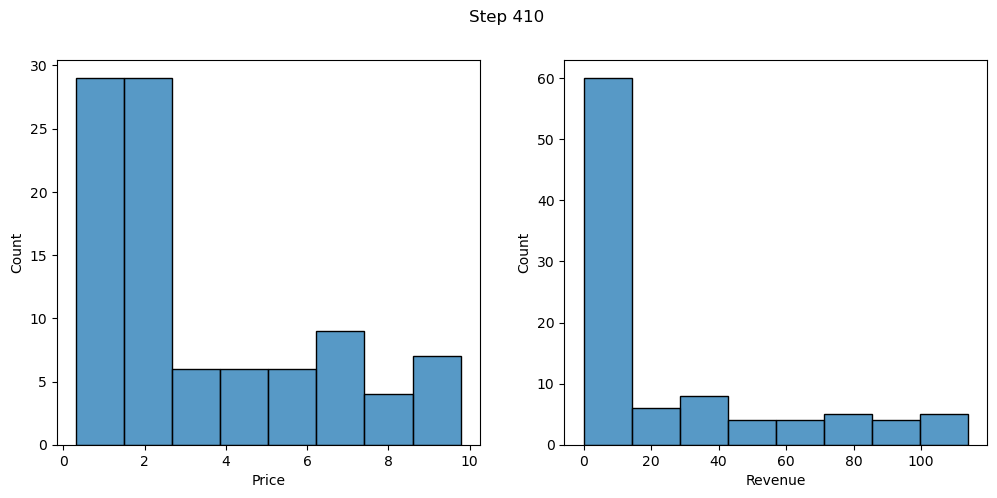

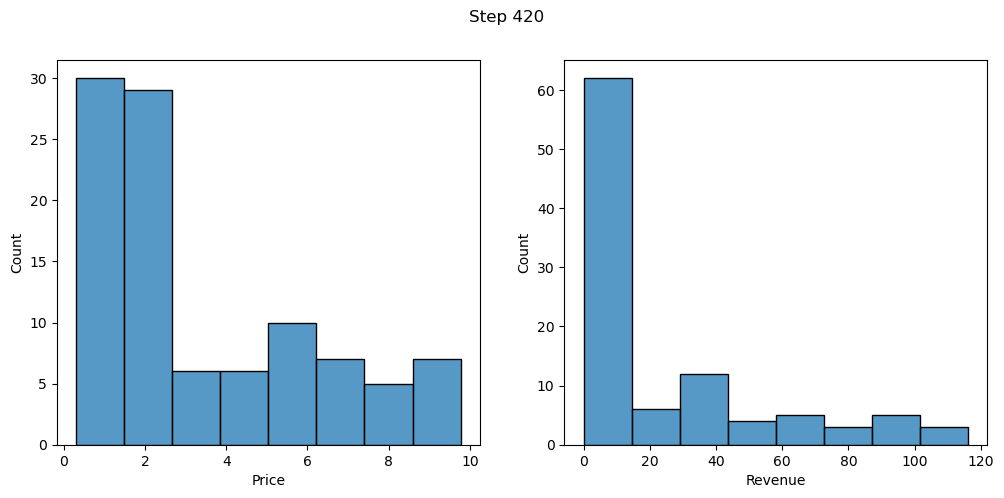

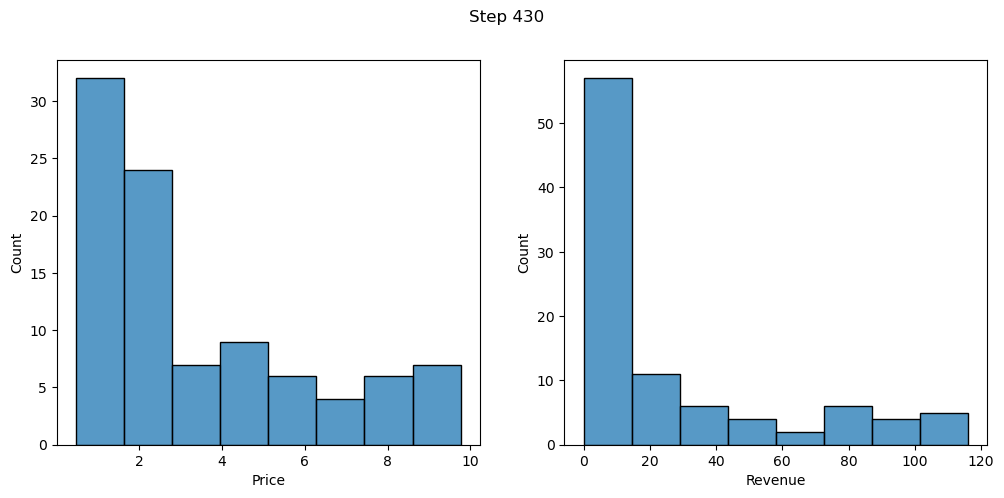

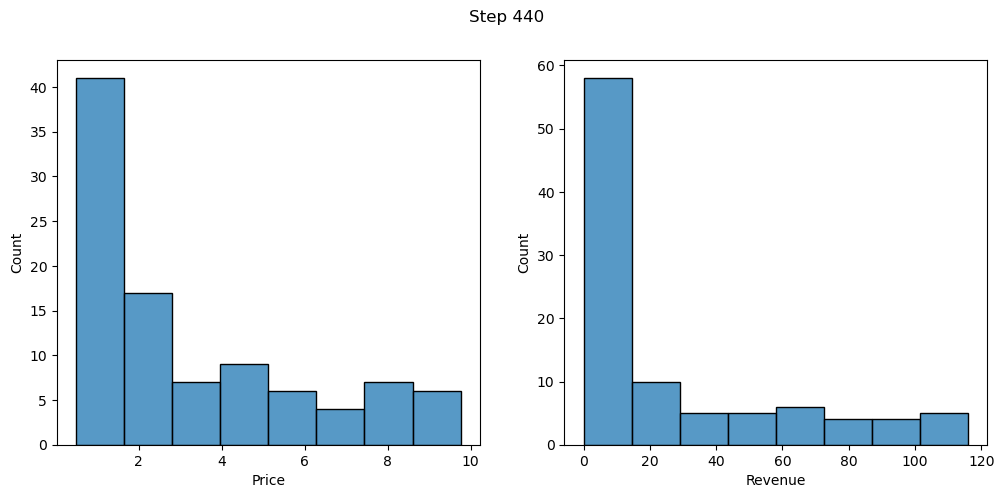

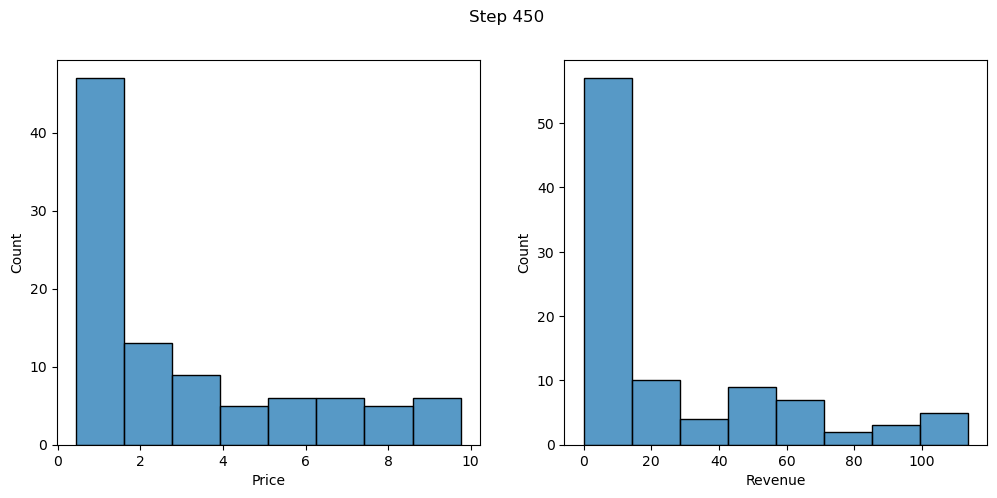

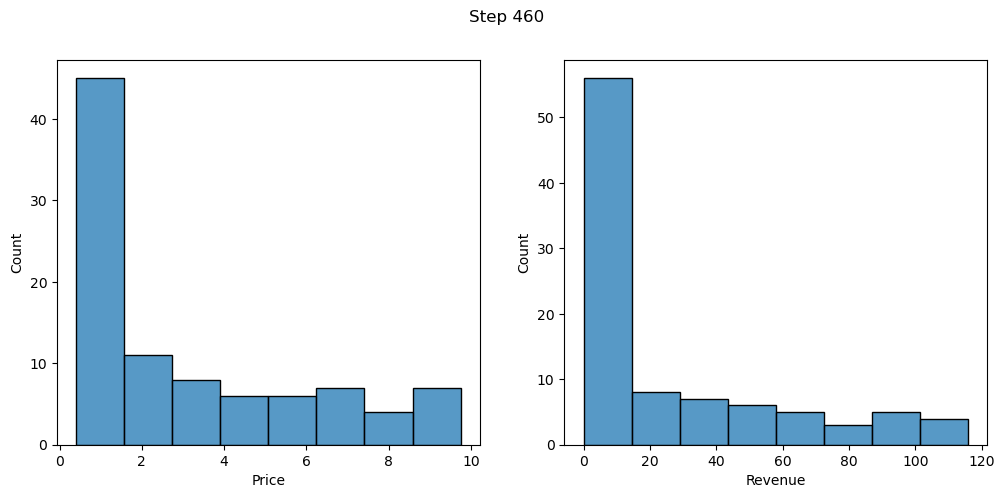

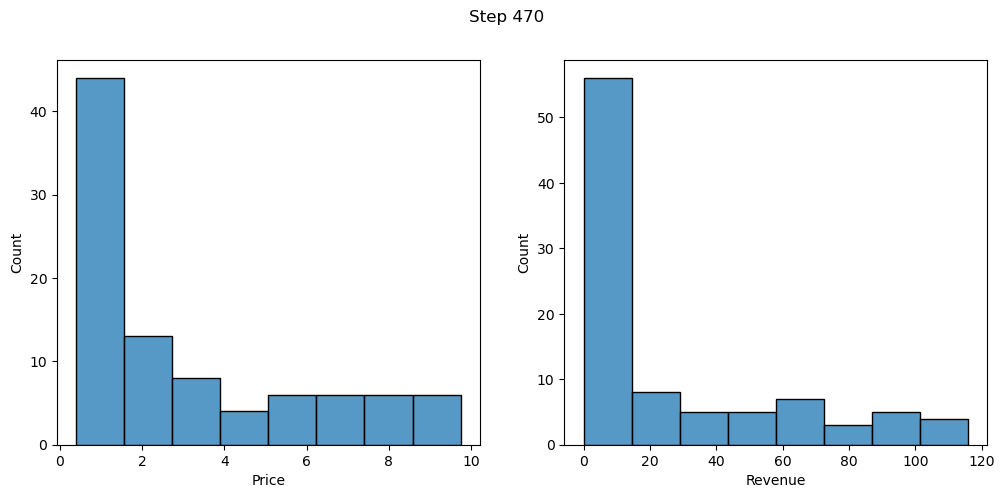

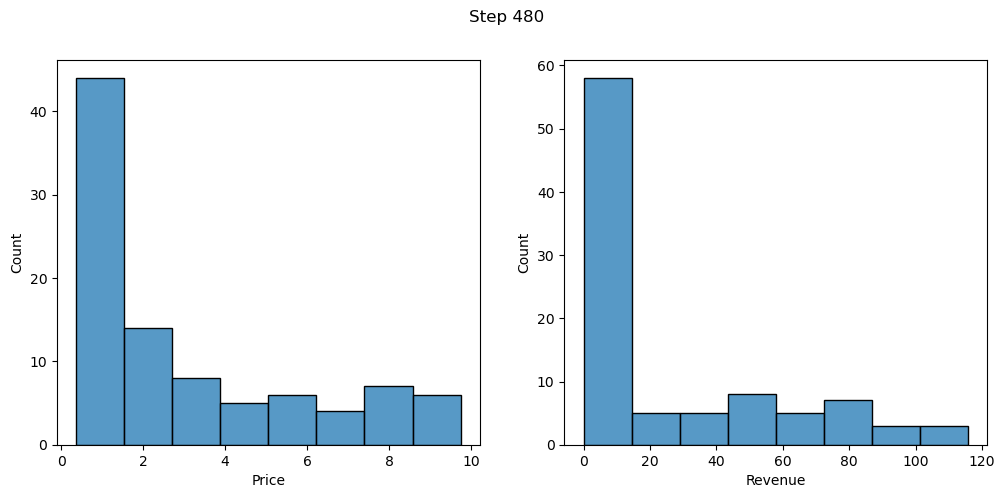

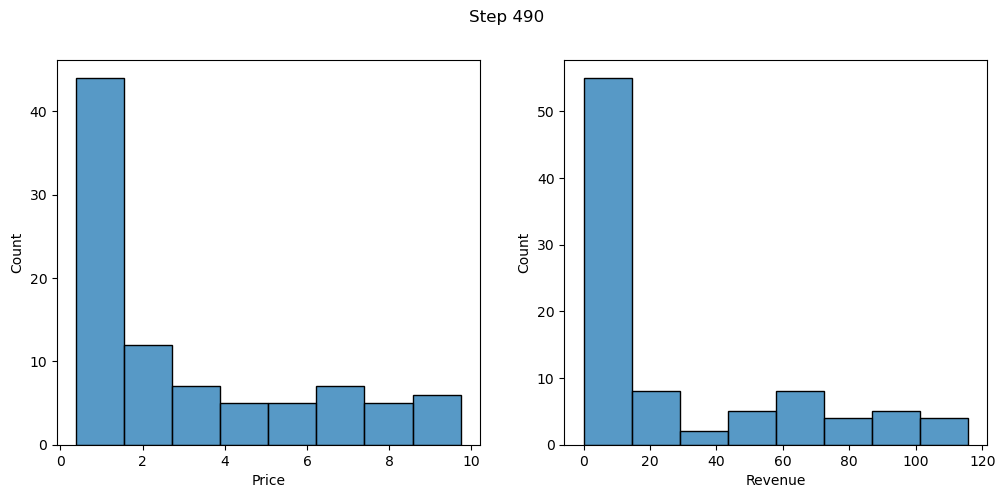

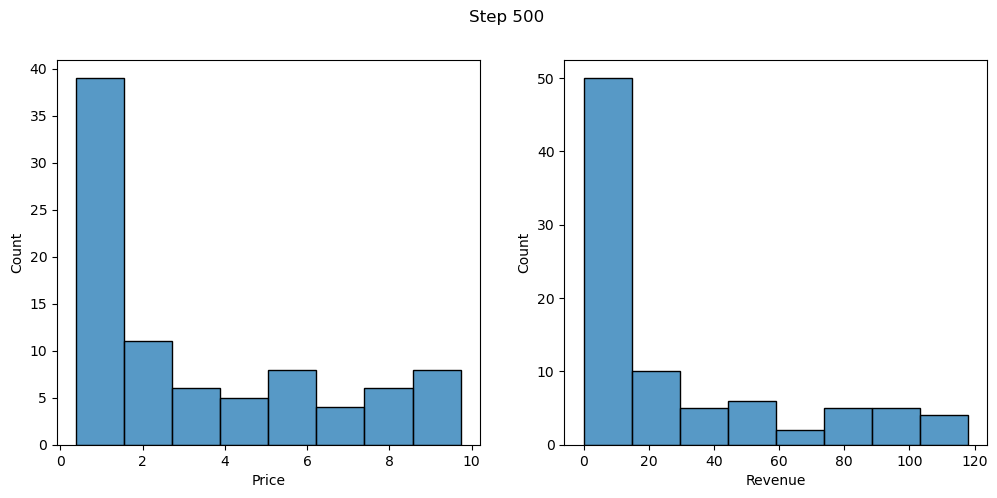

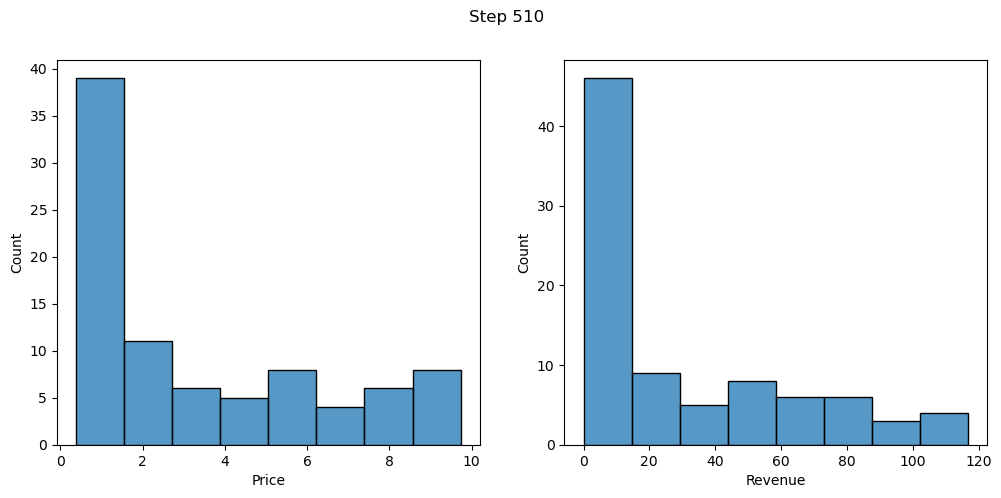

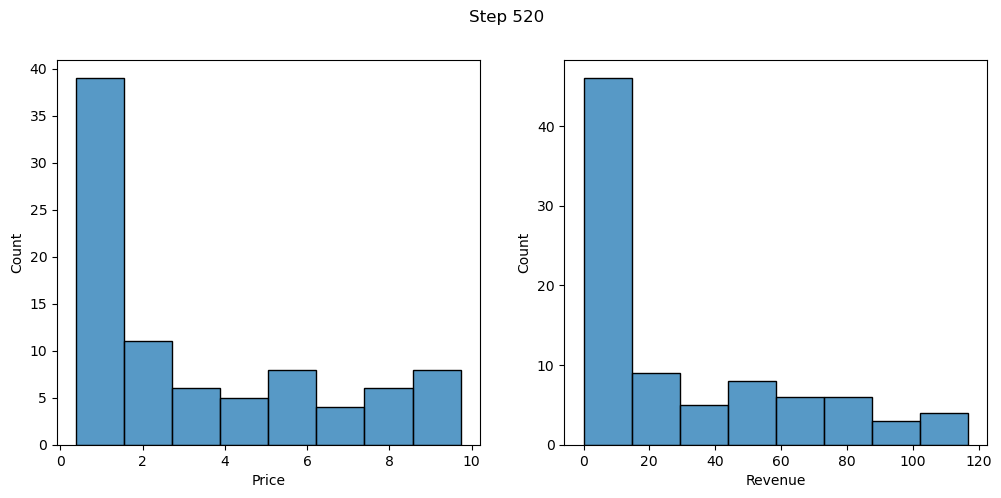

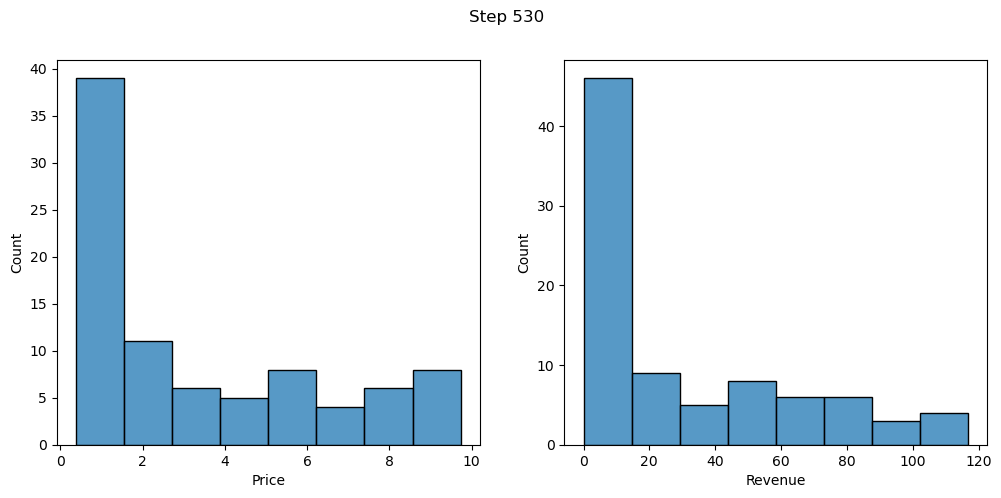

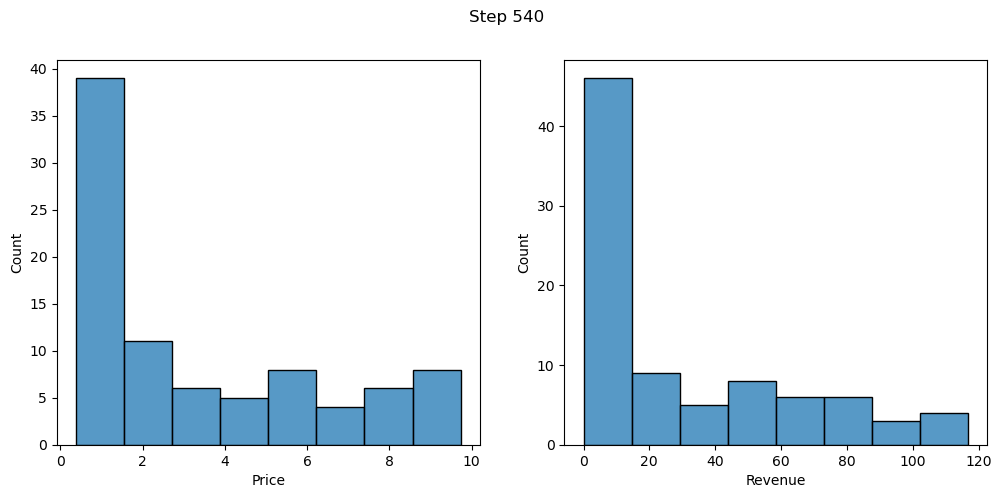

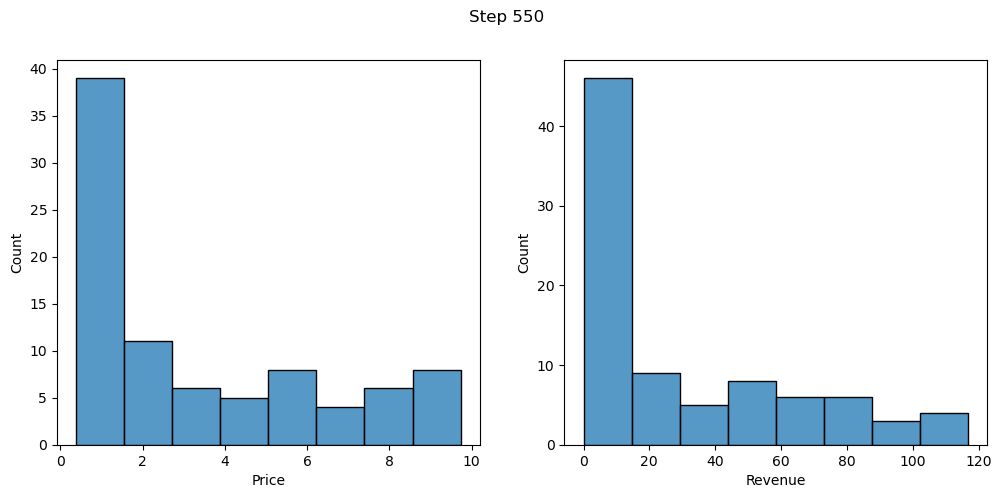

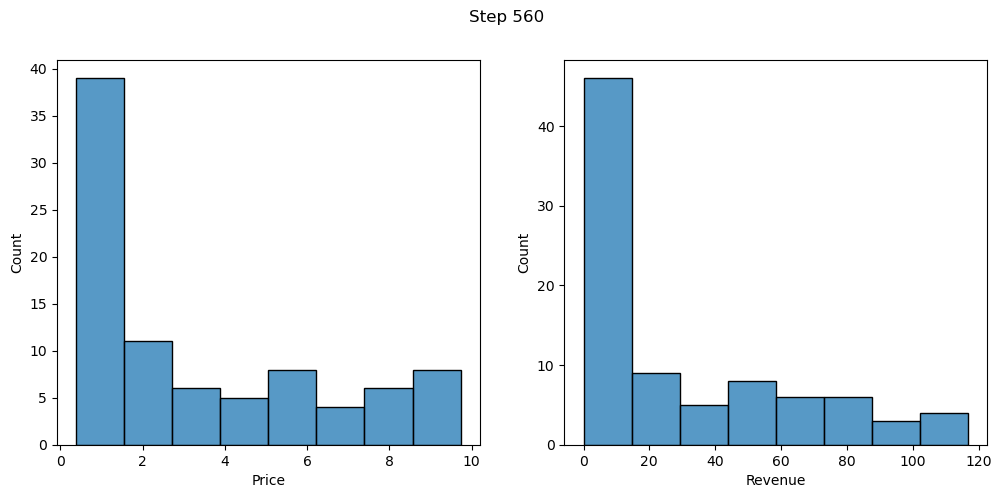

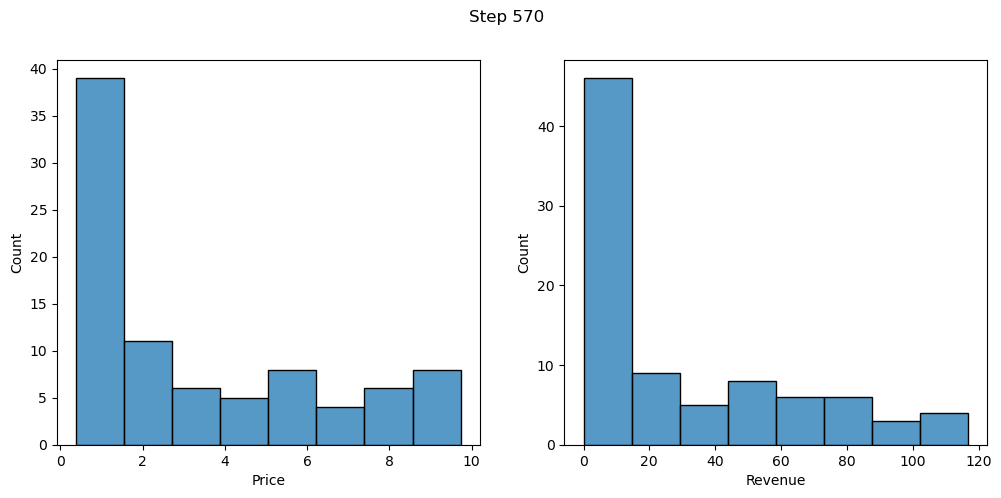

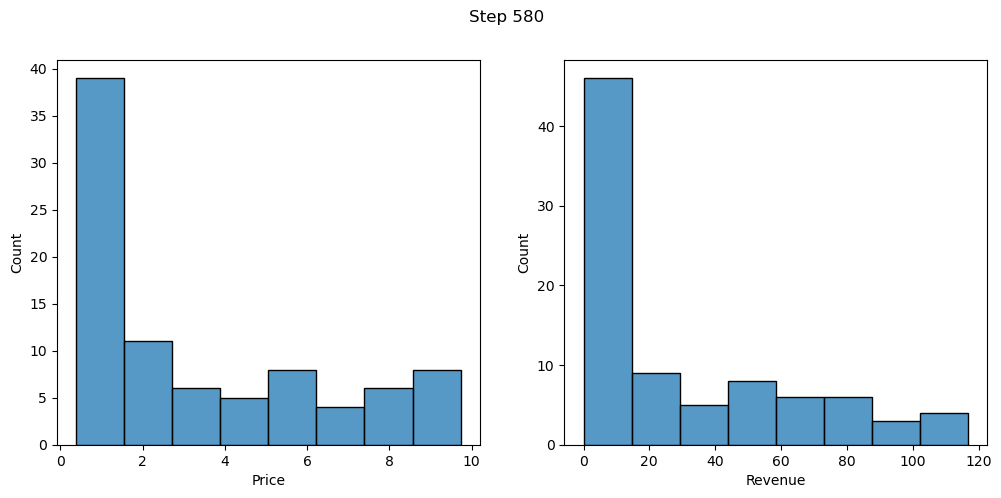

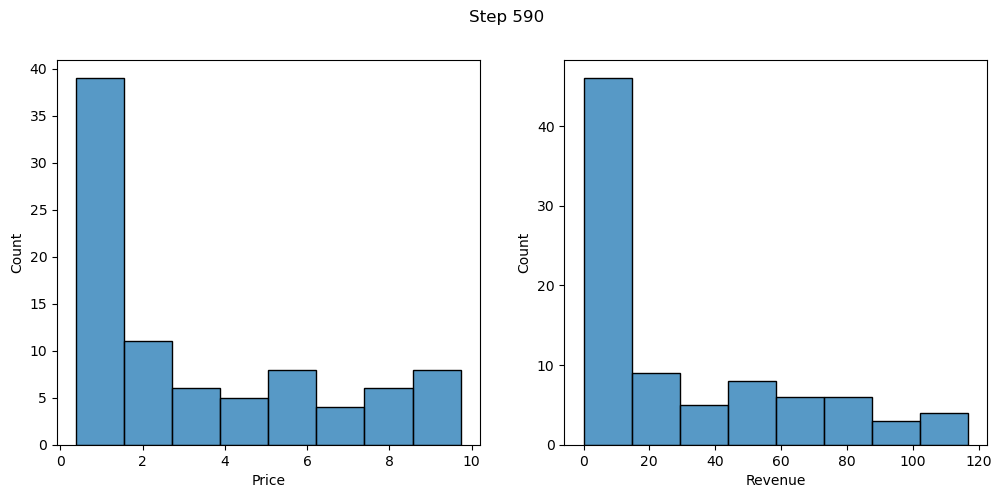

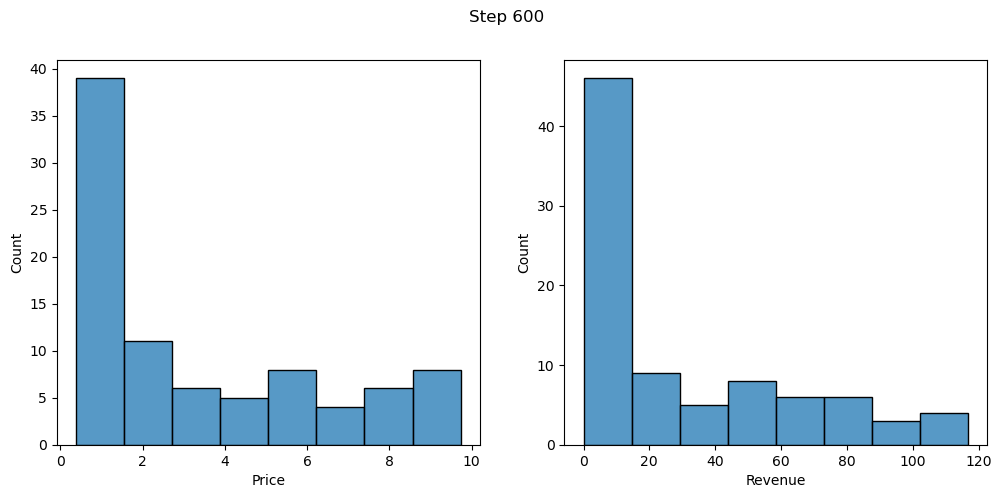

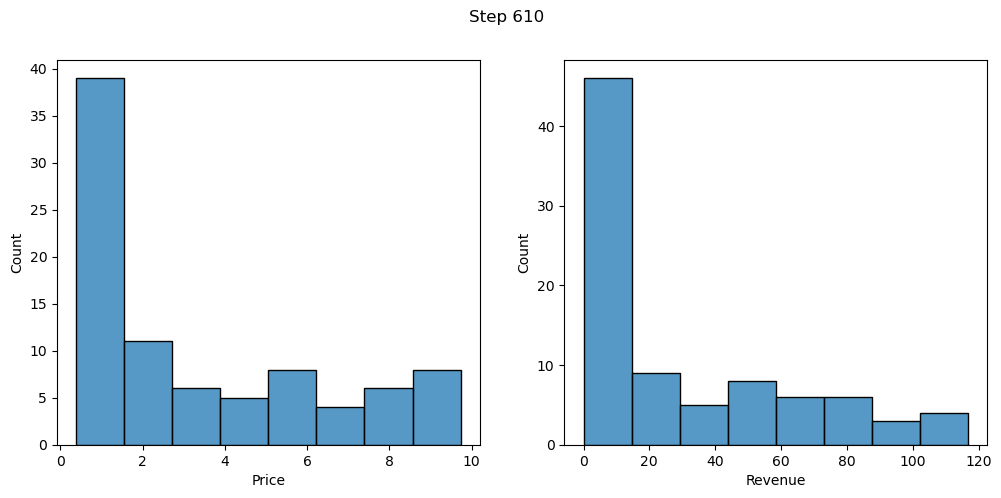

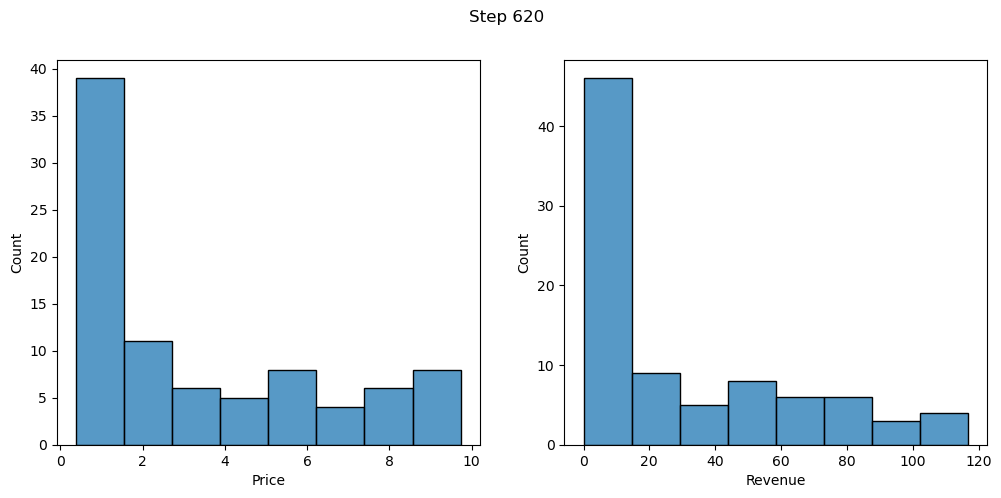

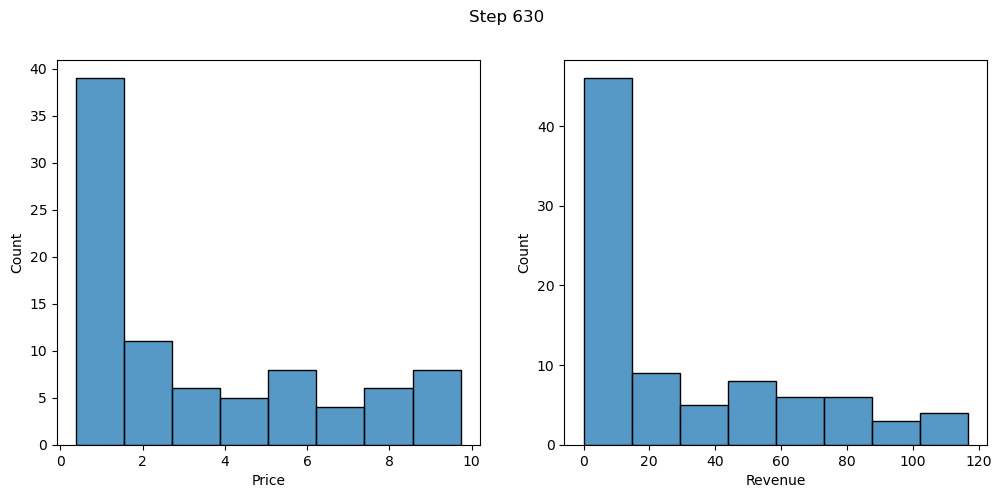

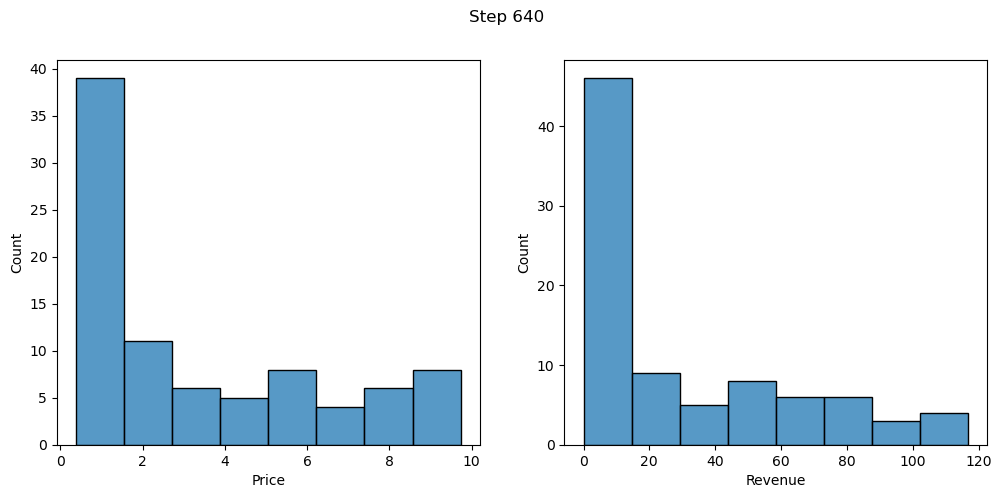

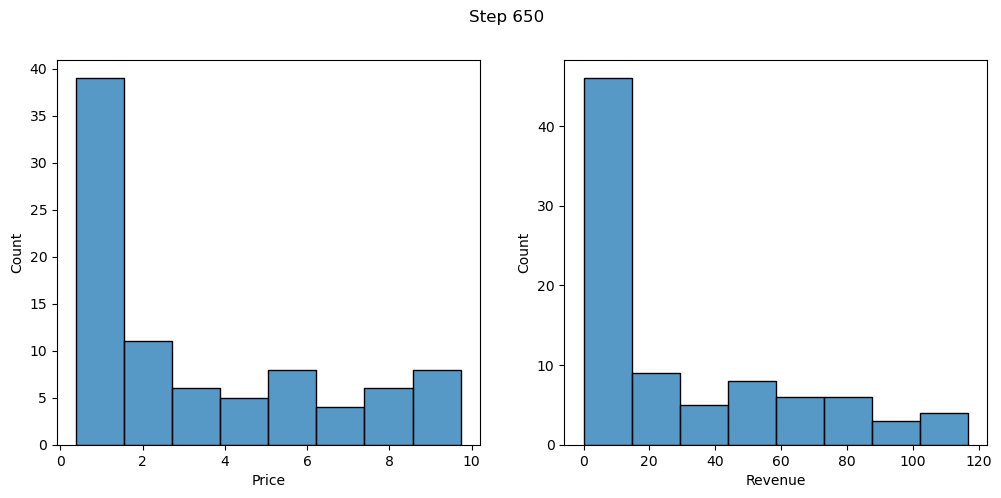

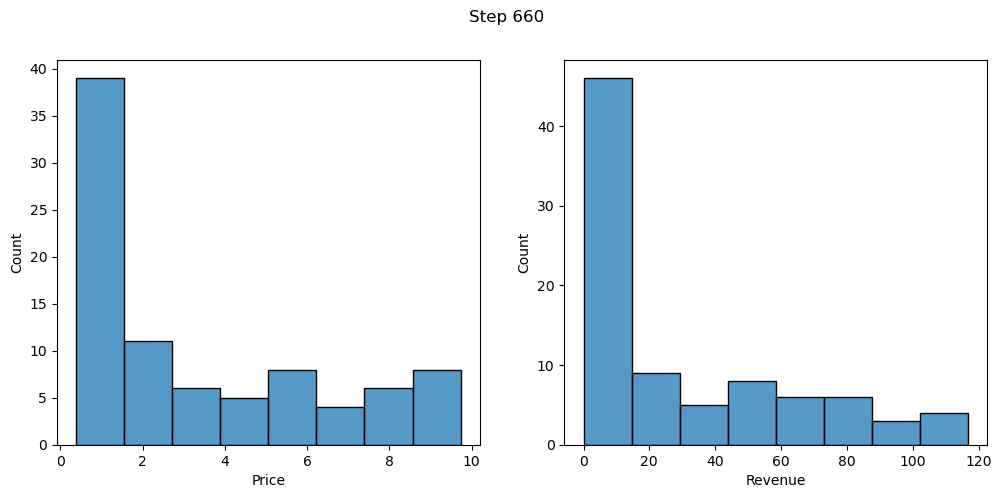

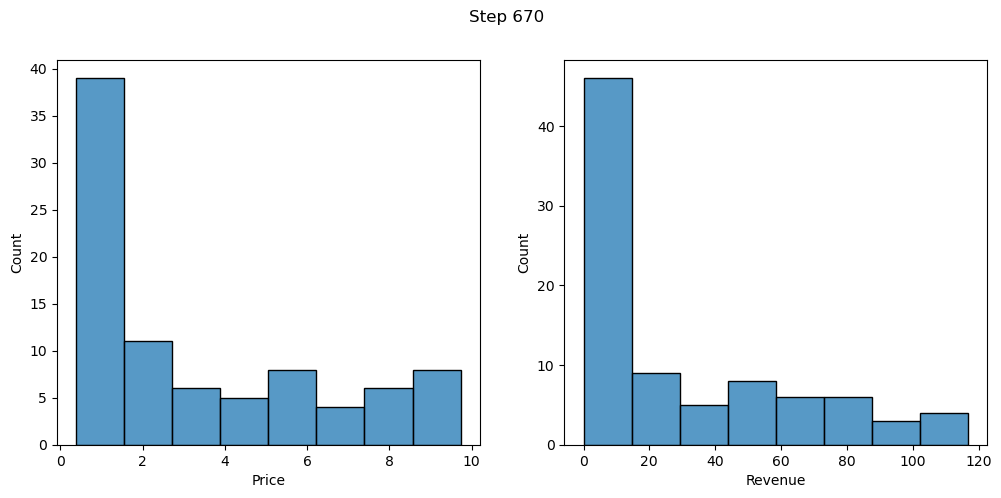

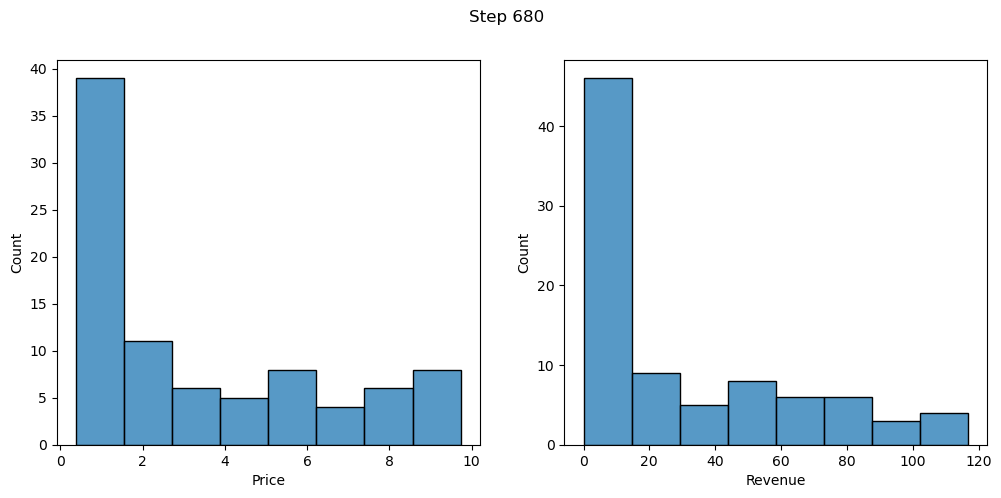

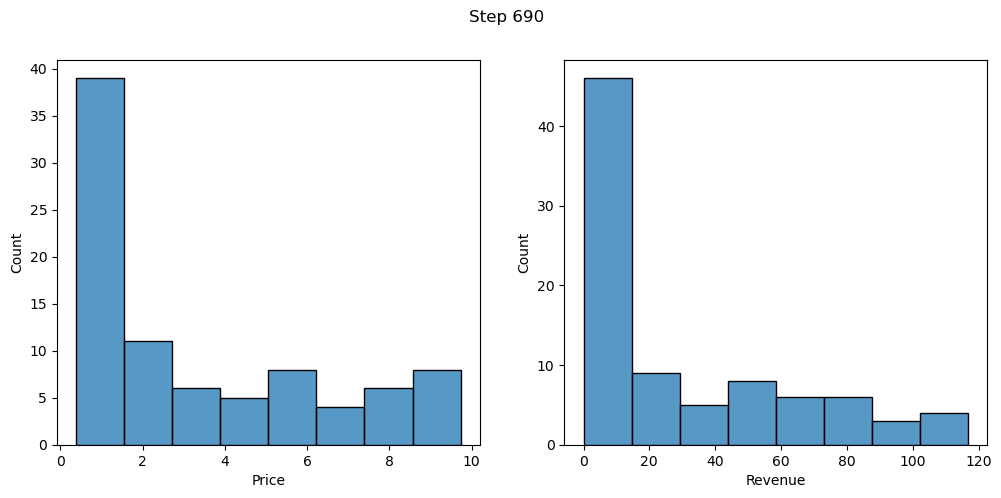

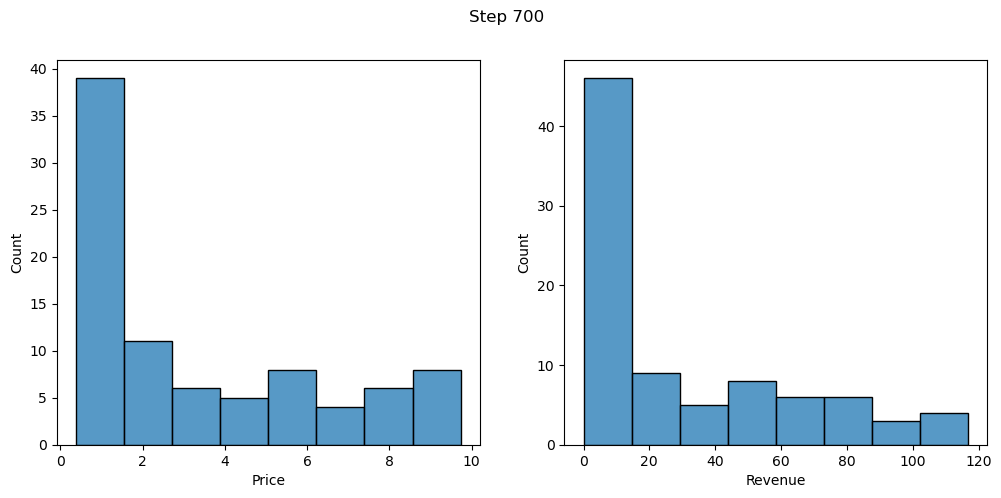

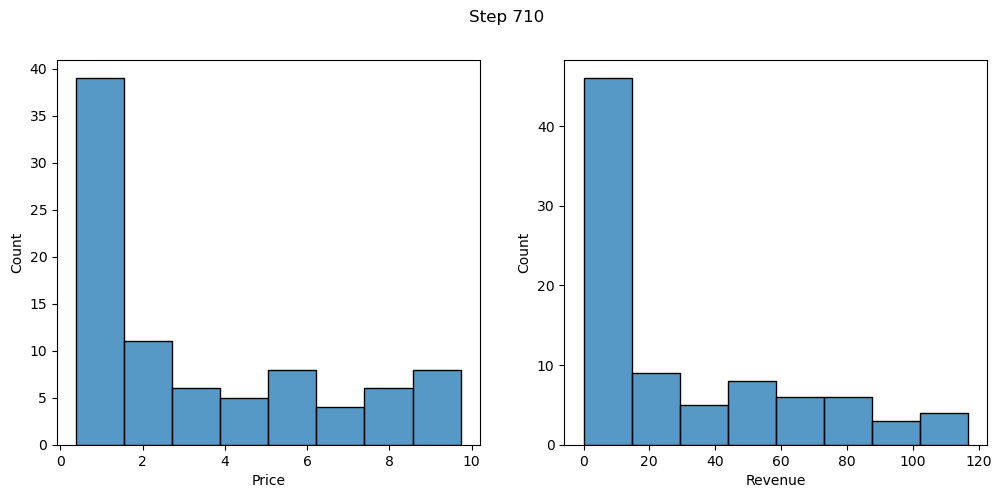

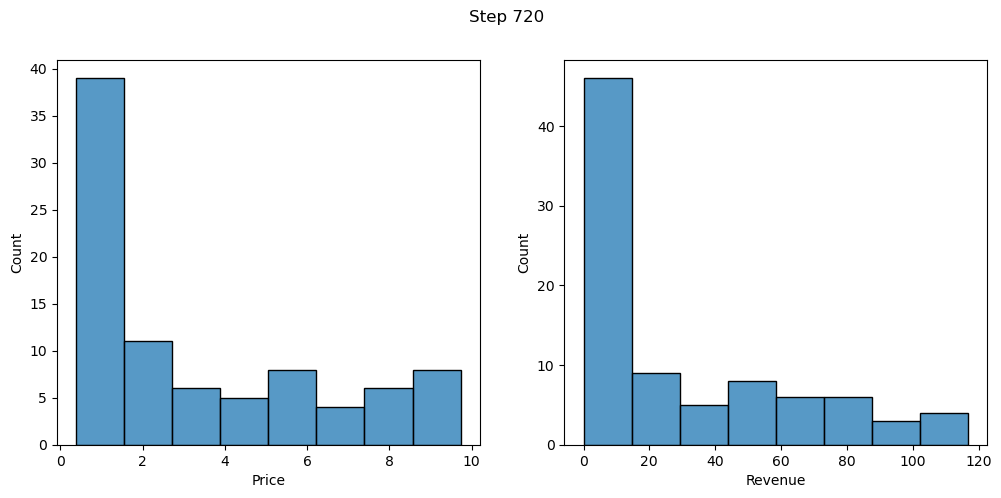

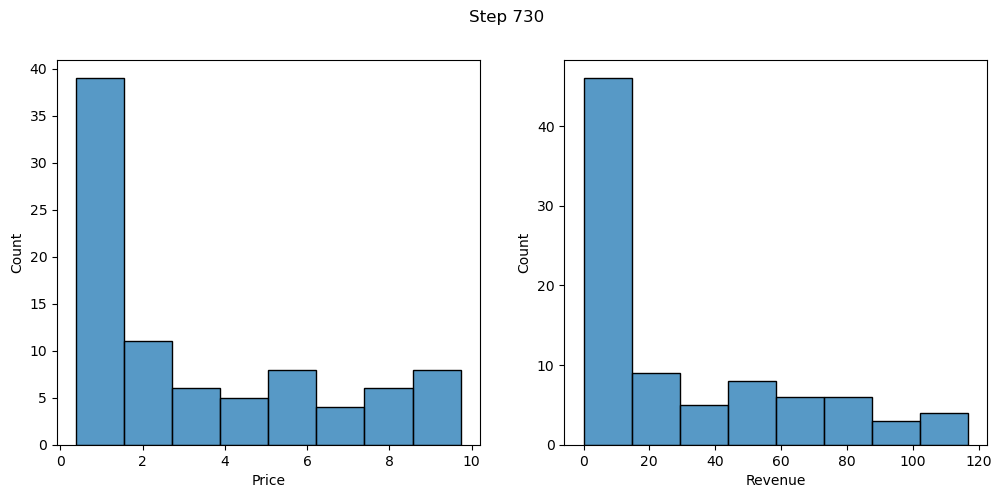

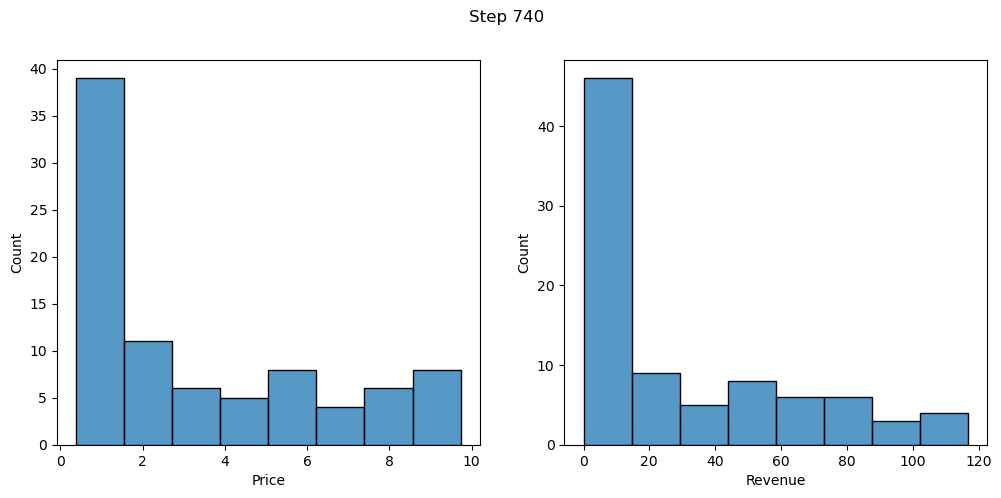

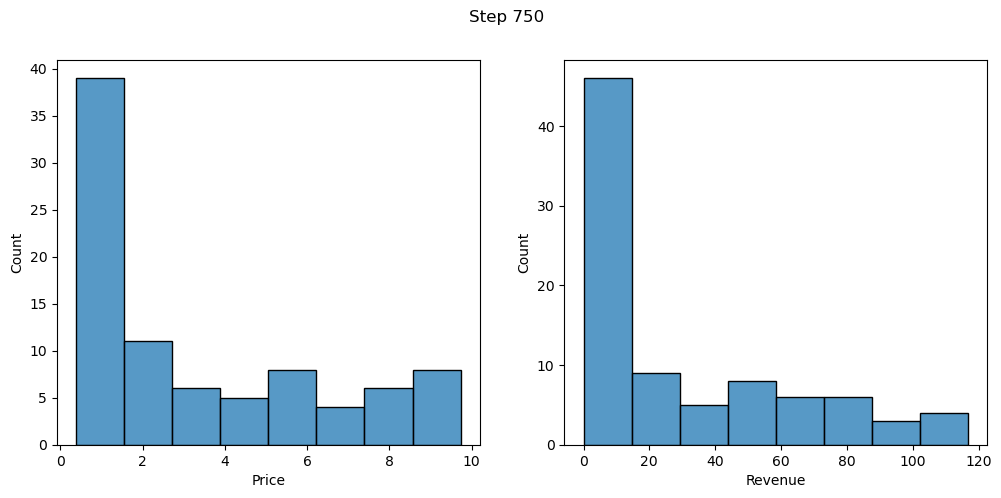

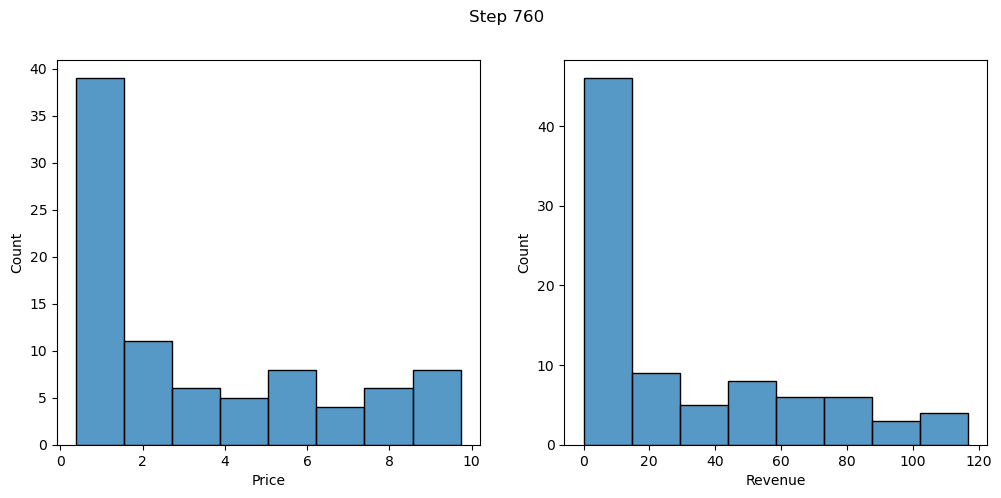

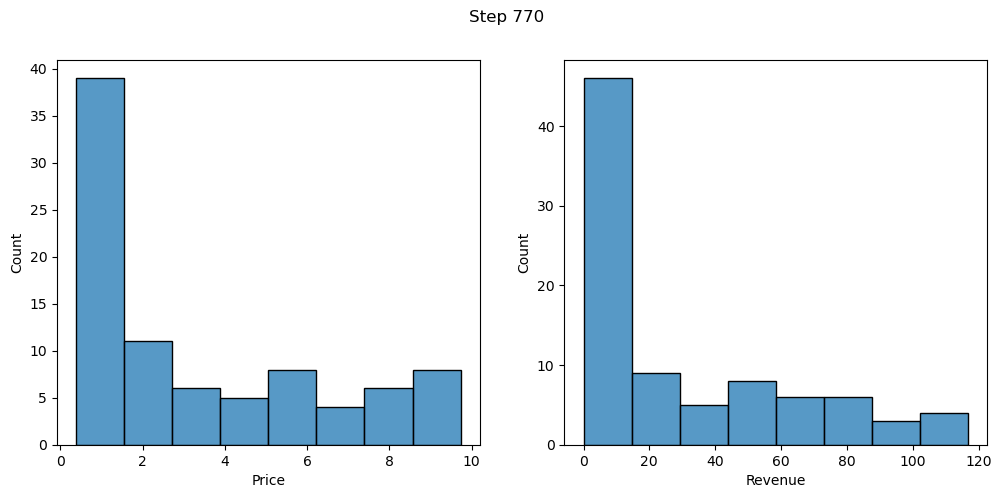

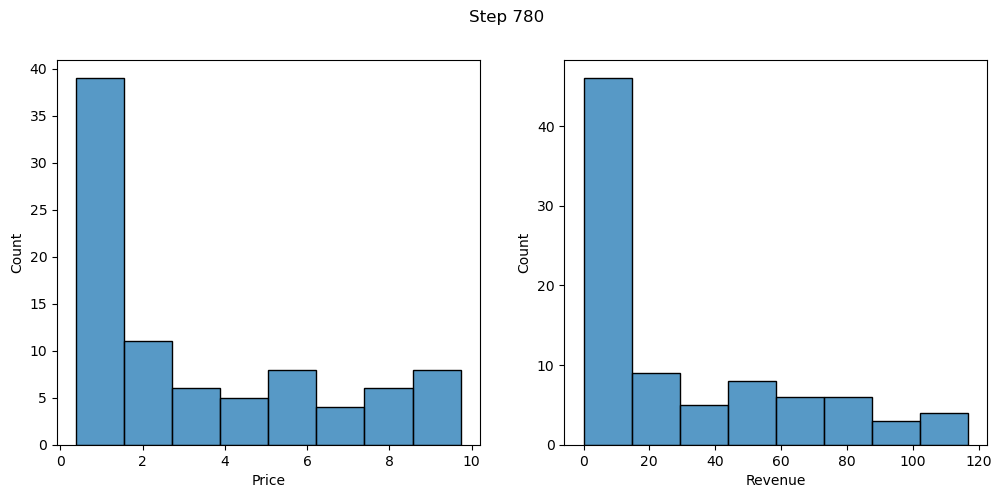

In [ ]:

# for each step plot use seaborn to do a 1x2 plot with the distribution of the "Price" and "Revenue" of the firms
for i in range(steps):
    if i % 10 == 0:
        df1 = df[df["Step"] == i]
        df1 = df1[df1["Type"] == "Firm"]
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        sns.histplot(df1["Price"], ax=ax[0])
        sns.histplot(df1["Revenue"], ax=ax[1])
        # set the title of the plot to the step
        fig.suptitle("Step " + str(i))
        plt.show()


In [ ]:
firms = df.loc[df['Type'] == "Firm"]
df.loc[(df['Type'] == "Firm") & (df['Step'] == 99)]['Revenue'].sum()
hhi = pd.DataFrame(data={'step': range(0,100)})
hhi = hhi.assign(volume=lambda x: df.loc[(df['Type'] == "Firm") & (df['Step'] == x.step)]['Revenue'].sum())
hhi 

ValueError: Can only compare identically-labeled Series objects